In [1]:
import os, re
from typing import Optional
import aiofiles

SQL_DIR: str = os.path.join(os.path.abspath("../../"), "sql/commands/com/de/insight2")

class SqlQuery:
    @staticmethod
    async def read_sql(sql_name) -> str:
        try:
            SQL_PATH = os.path.join(SQL_DIR, f'{sql_name}.sql')
            async with aiofiles.open(SQL_PATH, 'r', encoding='utf-8') as file:
                return await file.read()
        except FileNotFoundError:
            print(f"File {SQL_PATH} not found.")
            return ""
        except Exception as e:
            print(f"An error occurred while reading {SQL_PATH}: {e}")
            return ""

In [2]:
!pip install asyncpg
import asyncio
import asyncpg
import pandas as pd

print ("Fetching data...")

async def fetch_data(query: str):
    conn = await asyncpg.connect(
        host=os.environ.get("DB_HOST", "localhost"),
        port=5433,
        user=os.environ.get("DB_USER", "auth_user"),
        password=os.environ.get("DB_PASSWORD", "auth_password"),
        database=os.environ.get("DB_NAME", "auth_db")
    )

    rows = await conn.fetch(query)
    
    # Convert to pandas DataFrame
    df = pd.DataFrame(rows, columns=rows[0].keys() if rows else [])
    await conn.close()
    return df

Fetching data...


# -- Find which segments are used together in the same campaigns

In [3]:
SQL_NAME = "5_/5_1"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

,segment_1_name,segment_2_name,campaigns_together,days_together,clients_using_both
0,DO NOT SEND GAMBLING,Clicked Gaming,35,35,"Better Collective, Hatchster Ltd, Jumpman Gami..."
1,DO NOT SEND GAMBLING,Visited Gaming Redirect,27,26,"Better Collective, Gaming Redirect (cascade), ..."
2,Recent Registration + 1M,opened 5+ never clicked p,21,21,"Adstart Media, HeyPiggy (Jul25 Creative), Lead..."


SEGMENT OVERLAP & USER-LEVEL EXPOSURE RISK ANALYSIS

Analyzing 146 segment pairs
________________________________________________________________________________


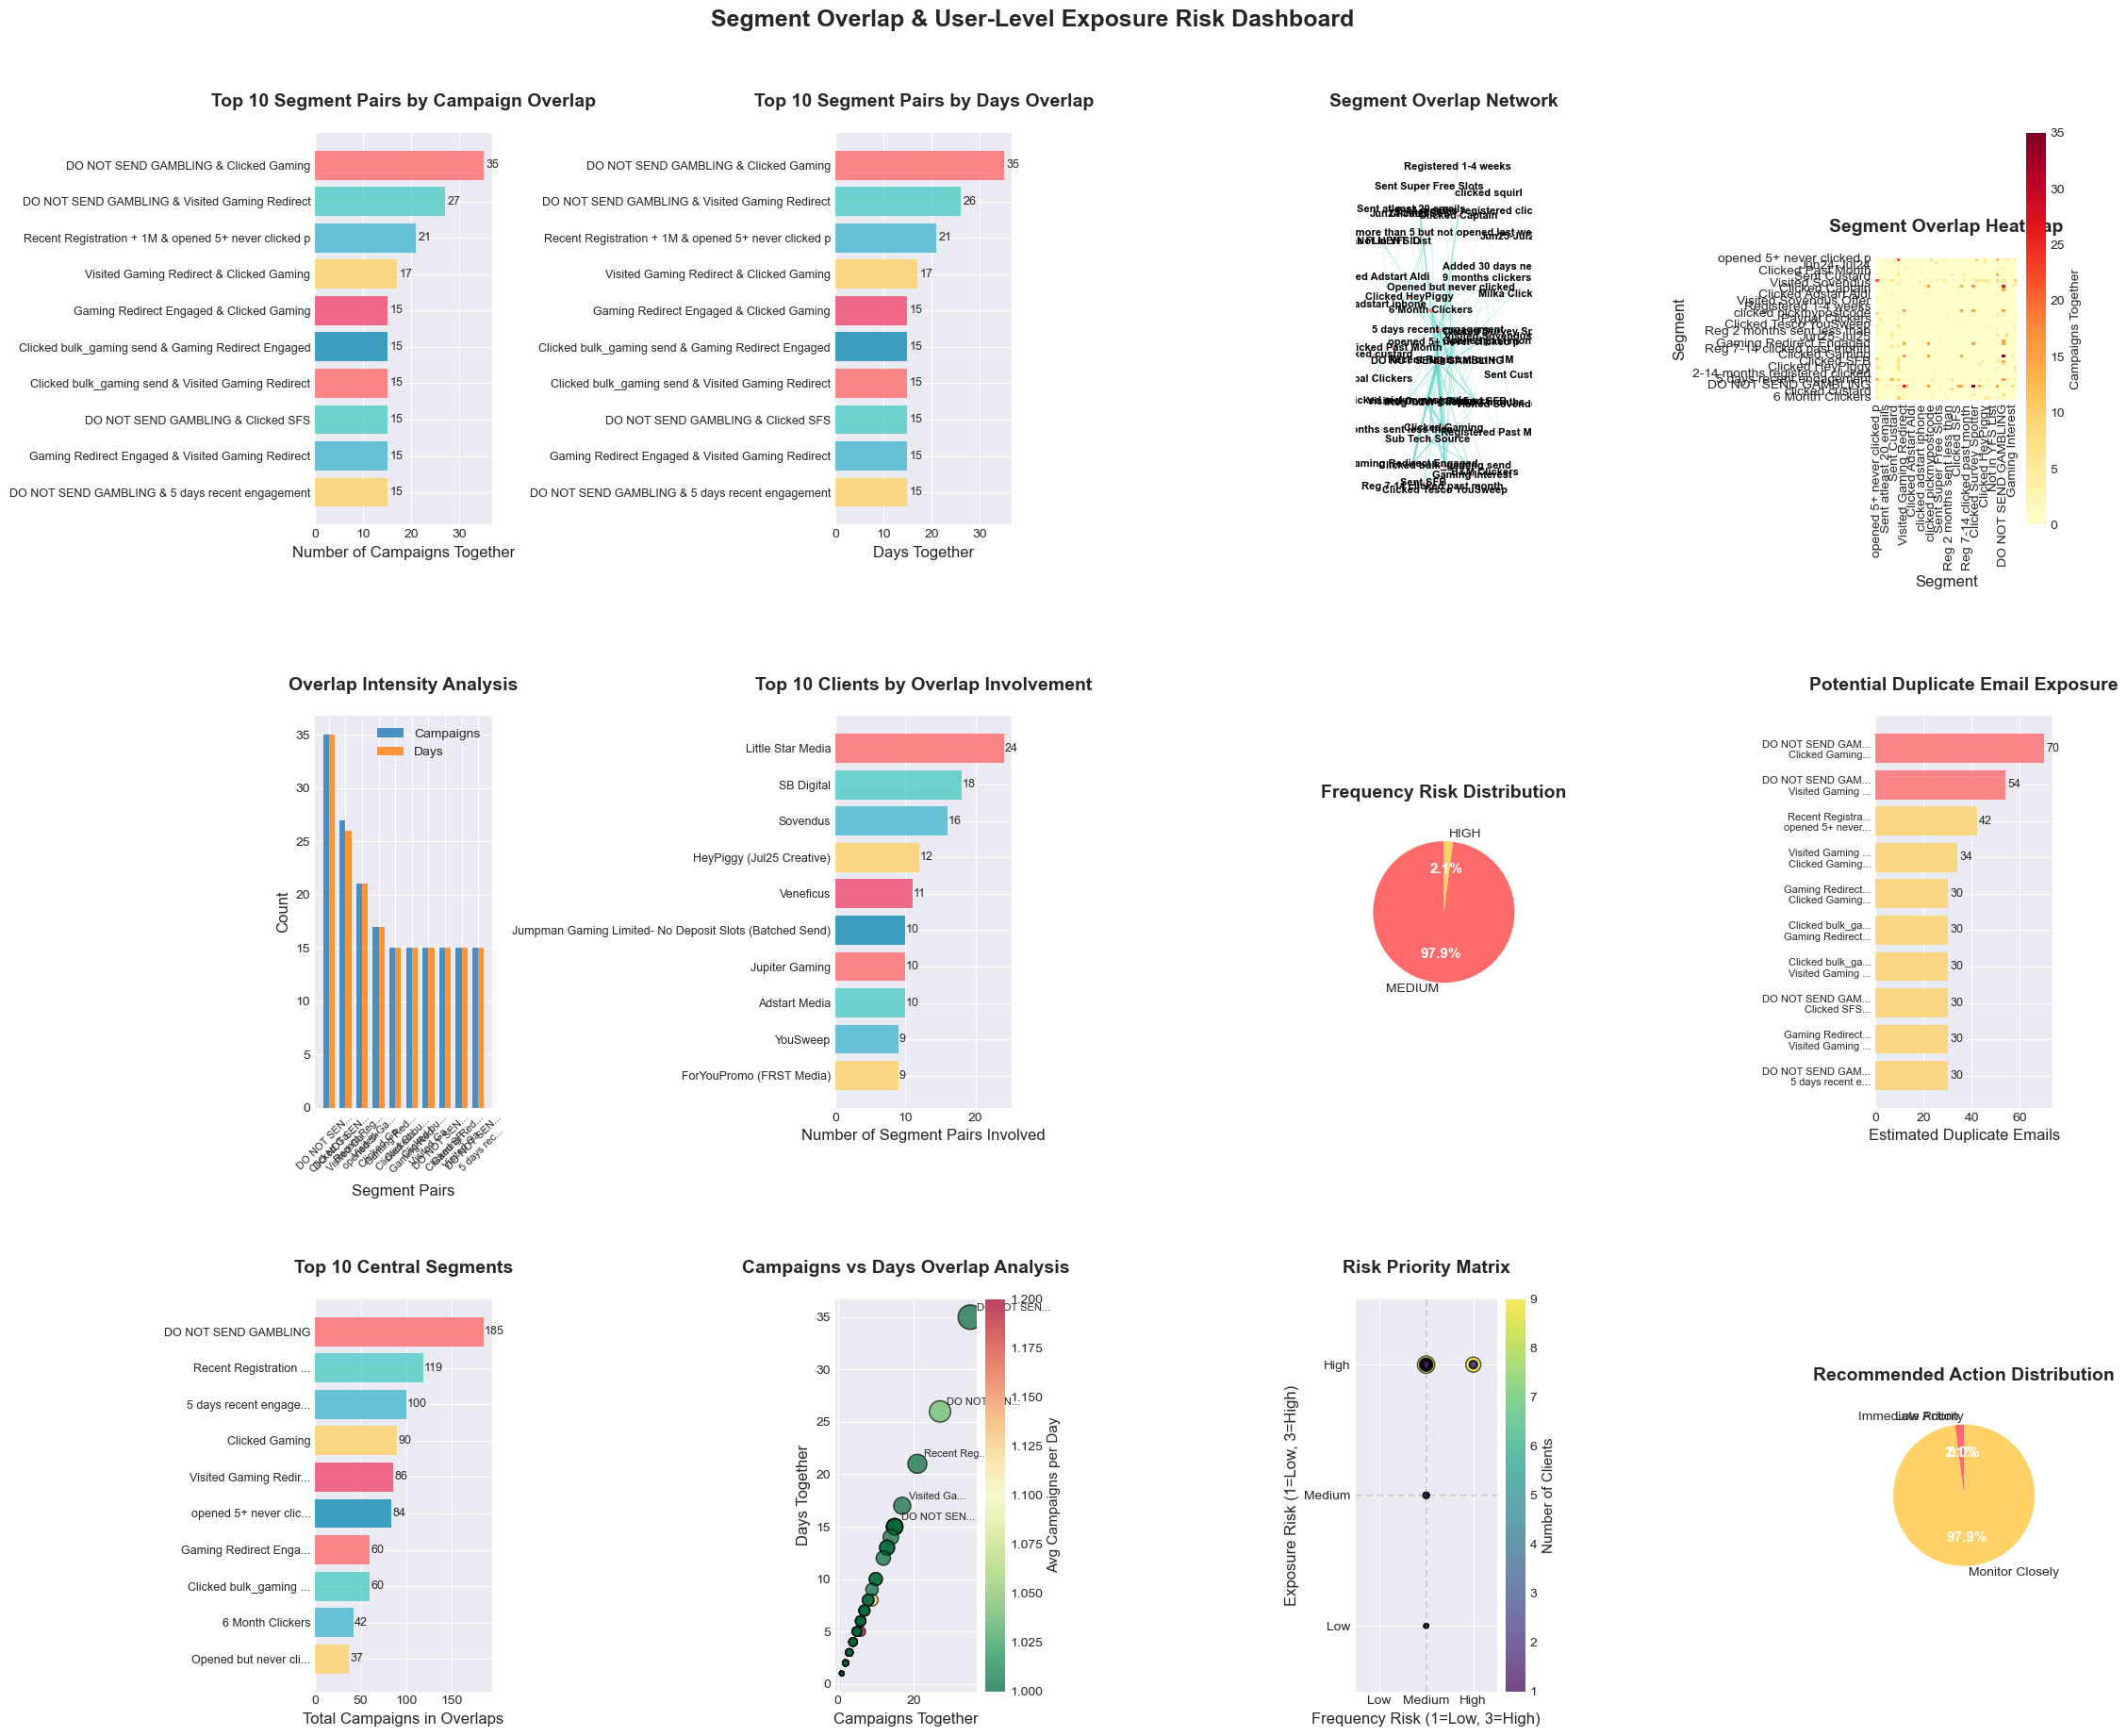


BUSINESS INSIGHTS & STRATEGIC RECOMMENDATIONS

    📊 SEGMENT OVERLAP & USER-LEVEL EXPOSURE ANALYSIS
    
    🎯 KEY FINDINGS:
    
    1. OVERLAP INTENSITY:
       • Highest overlap pair: "DO NOT SEND GAMBLING" & "Clicked Gaming" 
         (35 campaigns together)
       • Most days together: "DO NOT SEND GAMBLING" & "Clicked Gaming" 
         (35 days)
       • Average campaigns together per pair: 4.4
       • Average days together per pair: 4.4
    
    2. FREQUENCY RISKS:
       • High-risk pairs: 3 (>1.0 campaigns/day)
       • Medium-risk pairs: 143 (0.5-1 campaigns/day)
       • Average campaigns per day: 1.00
       • Highest frequency: "DO NOT SEND GAMBLING" & "Clicked Gaming" 
         (1.00 campaigns/day)
    
    3. EXPOSURE ANALYSIS:
       • Total estimated duplicate emails: 1286
       • Highest duplicate exposure: "DO NOT SEND GAMBLING" & "Clicked Gaming" 
         (70 duplicates)
       • Average duplicates per pair: 8.8
    
    4. SEGMENT CENTRALITY:
       • Most cent

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def analyze_segment_overlap_exposure(dataframe):
    """
    Comprehensive analysis of segment overlap and user-level exposure risks
    
    Parameters:
    dataframe (pd.DataFrame): Input data with segment overlap metrics
    
    Returns:
    dict: Dictionary containing insights, figure, and enhanced dataframe
    """
    
    # Create a copy to avoid modifying original
    df = dataframe.copy()
    
    # Clean client data - split by commas and strip whitespace
    df['clients_list'] = df['clients_using_both'].str.split(',').apply(
        lambda x: [client.strip() for client in x] if isinstance(x, list) else []
    )
    
    # Calculate additional metrics
    df['avg_campaigns_per_day_together'] = df['campaigns_together'] / df['days_together']
    df['overlap_intensity'] = (df['campaigns_together'] * df['days_together']) ** 0.5
    
    # Calculate potential user exposure
    # Assuming each campaign sends 1 email, but this could be adjusted
    df['estimated_duplicate_emails'] = df['campaigns_together'] * 2  # User gets both emails
    
    # Extract all unique segments
    all_segments = set(df['segment_1_name'].unique()) | set(df['segment_2_name'].unique())
    
    # Create a matrix of overlaps
    segment_list = list(all_segments)
    overlap_matrix = pd.DataFrame(0, index=segment_list, columns=segment_list)
    
    for _, row in df.iterrows():
        seg1, seg2 = row['segment_1_name'], row['segment_2_name']
        overlap_matrix.loc[seg1, seg2] = row['campaigns_together']
        overlap_matrix.loc[seg2, seg1] = row['campaigns_together']
    
    # Calculate segment centrality (how often a segment appears in overlaps)
    segment_centrality = {}
    for segment in segment_list:
        # Count overlaps for this segment
        overlaps = df[(df['segment_1_name'] == segment) | (df['segment_2_name'] == segment)]
        segment_centrality[segment] = {
            'total_campaigns_together': overlaps['campaigns_together'].sum(),
            'total_days_together': overlaps['days_together'].sum(),
            'num_overlapping_segments': len(overlaps),
            'clients_involved': len(set([client for sublist in overlaps['clients_list'] for client in sublist]))
        }
    
    # Create figure with subplots
    fig = plt.figure(figsize=(22, 18))
    
    # Color palette
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFD166', '#EF476F', '#118AB2']
    
    # 1. Top Overlapping Segment Pairs by Campaigns
    ax1 = plt.subplot(3, 4, 1)
    
    # Sort by campaigns_together and take top 10
    top_campaigns = df.sort_values('campaigns_together', ascending=False).head(10)
    
    bars1 = ax1.barh(range(len(top_campaigns)), top_campaigns['campaigns_together'],
                     color=colors[:len(top_campaigns)], alpha=0.8)
    
    ax1.set_yticks(range(len(top_campaigns)))
    ax1.set_yticklabels([f"{row['segment_1_name']} & {row['segment_2_name']}" 
                         for _, row in top_campaigns.iterrows()], fontsize=9)
    ax1.set_xlabel('Number of Campaigns Together', fontsize=12)
    ax1.set_title('Top 10 Segment Pairs by Campaign Overlap', fontsize=14, fontweight='bold', pad=20)
    ax1.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        ax1.text(width + 0.5, bar.get_y() + bar.get_height()/2,
                f'{width:.0f}', va='center', fontsize=9)
    
    # 2. Days Together Analysis
    ax2 = plt.subplot(3, 4, 2)
    
    top_days = df.sort_values('days_together', ascending=False).head(10)
    bars2 = ax2.barh(range(len(top_days)), top_days['days_together'],
                     color=colors[:len(top_days)], alpha=0.8)
    
    ax2.set_yticks(range(len(top_days)))
    ax2.set_yticklabels([f"{row['segment_1_name']} & {row['segment_2_name']}" 
                         for _, row in top_days.iterrows()], fontsize=9)
    ax2.set_xlabel('Days Together', fontsize=12)
    ax2.set_title('Top 10 Segment Pairs by Days Overlap', fontsize=14, fontweight='bold', pad=20)
    ax2.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2,
                f'{width:.0f}', va='center', fontsize=9)
    
    # 3. Network Graph of Segment Overlaps
    ax3 = plt.subplot(3, 4, 3)
    
    # Create graph
    G = nx.Graph()
    
    # Add nodes
    for segment in segment_list:
        G.add_node(segment, size=segment_centrality[segment]['total_campaigns_together'] / 100)
    
    # Add edges with weights
    for _, row in df.iterrows():
        G.add_edge(row['segment_1_name'], row['segment_2_name'], 
                  weight=row['campaigns_together'] / 10)
    
    # Calculate positions
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Draw network
    node_sizes = [segment_centrality[node]['total_campaigns_together'] / 10 for node in G.nodes()]
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                          node_color='#FF6B6B', alpha=0.8, ax=ax3)
    nx.draw_networkx_edges(G, pos, width=edge_weights, 
                          edge_color='#4ECDC4', alpha=0.5, ax=ax3)
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax3)
    
    ax3.set_title('Segment Overlap Network', fontsize=14, fontweight='bold', pad=20)
    ax3.axis('off')
    
    # 4. Heatmap of Campaign Overlaps
    ax4 = plt.subplot(3, 4, 4)
    
    # Create heatmap
    sns.heatmap(overlap_matrix, cmap='YlOrRd', square=True, 
                cbar_kws={'label': 'Campaigns Together'}, ax=ax4)
    
    ax4.set_title('Segment Overlap Heatmap', fontsize=14, fontweight='bold', pad=20)
    ax4.set_xlabel('Segment', fontsize=12)
    ax4.set_ylabel('Segment', fontsize=12)
    ax4.tick_params(axis='x', rotation=90)
    ax4.tick_params(axis='y', rotation=0)
    
    # 5. Overlap Intensity Analysis
    ax5 = plt.subplot(3, 4, 5)
    
    # Sort by overlap intensity
    df_intensity = df.sort_values('overlap_intensity', ascending=False).head(10)
    
    x = np.arange(len(df_intensity))
    width = 0.35
    
    bars5a = ax5.bar(x - width/2, df_intensity['campaigns_together'], width,
                     label='Campaigns', color='#1F77B4', alpha=0.8)
    bars5b = ax5.bar(x + width/2, df_intensity['days_together'], width,
                     label='Days', color='#FF7F0E', alpha=0.8)
    
    ax5.set_title('Overlap Intensity Analysis', fontsize=14, fontweight='bold', pad=20)
    ax5.set_xlabel('Segment Pairs', fontsize=12)
    ax5.set_ylabel('Count', fontsize=12)
    ax5.set_xticks(x)
    ax5.set_xticklabels([f"{row['segment_1_name'][:10]}...\n{row['segment_2_name'][:10]}..." 
                         for _, row in df_intensity.iterrows()], rotation=45, fontsize=8)
    ax5.legend()
    
    # 6. Client Distribution Analysis
    ax6 = plt.subplot(3, 4, 6)
    
    # Count client appearances
    client_counts = {}
    for clients in df['clients_list']:
        for client in clients:
            client_counts[client] = client_counts.get(client, 0) + 1
    
    # Get top clients
    top_clients = sorted(client_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    client_names = [client[0] for client in top_clients]
    client_values = [client[1] for client in top_clients]
    
    bars6 = ax6.barh(range(len(client_names)), client_values,
                     color=colors[:len(client_names)], alpha=0.8)
    
    ax6.set_yticks(range(len(client_names)))
    ax6.set_yticklabels(client_names, fontsize=9)
    ax6.set_xlabel('Number of Segment Pairs Involved', fontsize=12)
    ax6.set_title('Top 10 Clients by Overlap Involvement', fontsize=14, fontweight='bold', pad=20)
    ax6.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars6):
        width = bar.get_width()
        ax6.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                f'{width:.0f}', va='center', fontsize=9)
    
    # 7. Frequency Analysis - Campaigns per Day Together
    ax7 = plt.subplot(3, 4, 7)
    
    # Calculate frequency risk score
    df['frequency_risk'] = df['avg_campaigns_per_day_together'].apply(
        lambda x: 'HIGH' if x > 1 else 'MEDIUM' if x > 0.5 else 'LOW'
    )
    
    risk_counts = df['frequency_risk'].value_counts()
    wedges7, texts7, autotexts7 = ax7.pie(risk_counts.values, labels=risk_counts.index,
                                           autopct='%1.1f%%', colors=['#FF6B6B', '#FFD166', '#4ECDC4'],
                                           startangle=90)
    
    ax7.set_title('Frequency Risk Distribution', fontsize=14, fontweight='bold', pad=20)
    
    for autotext in autotexts7:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # 8. Estimated Duplicate Email Exposure
    ax8 = plt.subplot(3, 4, 8)
    
    top_duplicates = df.sort_values('estimated_duplicate_emails', ascending=False).head(10)
    
    bars8 = ax8.barh(range(len(top_duplicates)), top_duplicates['estimated_duplicate_emails'],
                     color=['#FF6B6B' if x > 50 else '#FFD166' if x > 20 else '#4ECDC4' 
                            for x in top_duplicates['estimated_duplicate_emails']],
                     alpha=0.8)
    
    ax8.set_yticks(range(len(top_duplicates)))
    ax8.set_yticklabels([f"{row['segment_1_name'][:15]}...\n{row['segment_2_name'][:15]}..." 
                         for _, row in top_duplicates.iterrows()], fontsize=8)
    ax8.set_xlabel('Estimated Duplicate Emails', fontsize=12)
    ax8.set_title('Potential Duplicate Email Exposure', fontsize=14, fontweight='bold', pad=20)
    ax8.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars8):
        width = bar.get_width()
        ax8.text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{width:.0f}', va='center', fontsize=9)
    
    # 9. Segment Centrality Analysis
    ax9 = plt.subplot(3, 4, 9)
    
    # Get top central segments
    centrality_df = pd.DataFrame(segment_centrality).T
    centrality_df['segment'] = centrality_df.index
    top_central = centrality_df.sort_values('total_campaigns_together', ascending=False).head(10)
    
    bars9 = ax9.barh(range(len(top_central)), top_central['total_campaigns_together'],
                     color=colors[:len(top_central)], alpha=0.8)
    
    ax9.set_yticks(range(len(top_central)))
    ax9.set_yticklabels([segment[:20] + '...' if len(segment) > 20 else segment 
                         for segment in top_central.index], fontsize=9)
    ax9.set_xlabel('Total Campaigns in Overlaps', fontsize=12)
    ax9.set_title('Top 10 Central Segments', fontsize=14, fontweight='bold', pad=20)
    ax9.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars9):
        width = bar.get_width()
        ax9.text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{width:.0f}', va='center', fontsize=9)
    
    # 10. Campaigns vs Days Scatter Plot
    ax10 = plt.subplot(3, 4, 10)
    
    scatter10 = ax10.scatter(df['campaigns_together'], df['days_together'],
                            s=df['overlap_intensity'] * 10,
                            c=df['avg_campaigns_per_day_together'], cmap='RdYlGn_r',
                            alpha=0.7, edgecolors='black')
    
    ax10.set_title('Campaigns vs Days Overlap Analysis', fontsize=14, fontweight='bold', pad=20)
    ax10.set_xlabel('Campaigns Together', fontsize=12)
    ax10.set_ylabel('Days Together', fontsize=12)
    
    # Add segment pair labels for top overlaps
    top_pairs = df.nlargest(5, 'overlap_intensity')
    for _, row in top_pairs.iterrows():
        ax10.annotate(f"{row['segment_1_name'][:10]}...", 
                     (row['campaigns_together'], row['days_together']),
                     xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Add colorbar
    cbar10 = plt.colorbar(scatter10, ax=ax10)
    cbar10.set_label('Avg Campaigns per Day', fontsize=11)
    
    # 11. Risk Priority Matrix
    ax11 = plt.subplot(3, 4, 11)
    
    # Calculate risk scores
    df['exposure_risk'] = pd.qcut(df['estimated_duplicate_emails'], 3, labels=['LOW', 'MEDIUM', 'HIGH'])
    df['frequency_risk_num'] = df['frequency_risk'].map({'LOW': 1, 'MEDIUM': 2, 'HIGH': 3})
    df['exposure_risk_num'] = df['exposure_risk'].cat.codes + 1
    
    # Create bubble chart
    scatter11 = ax11.scatter(df['frequency_risk_num'], df['exposure_risk_num'],
                            s=df['overlap_intensity'] * 5,
                            c=df['clients_list'].apply(len), cmap='viridis',
                            alpha=0.7, edgecolors='black')
    
    ax11.set_title('Risk Priority Matrix', fontsize=14, fontweight='bold', pad=20)
    ax11.set_xlabel('Frequency Risk (1=Low, 3=High)', fontsize=12)
    ax11.set_ylabel('Exposure Risk (1=Low, 3=High)', fontsize=12)
    ax11.set_xlim(0.5, 3.5)
    ax11.set_ylim(0.5, 3.5)
    ax11.set_xticks([1, 2, 3])
    ax11.set_xticklabels(['Low', 'Medium', 'High'])
    ax11.set_yticks([1, 2, 3])
    ax11.set_yticklabels(['Low', 'Medium', 'High'])
    
    # Add quadrant lines
    ax11.axhline(y=2, color='gray', linestyle='--', alpha=0.3)
    ax11.axvline(x=2, color='gray', linestyle='--', alpha=0.3)
    
    # Add colorbar
    cbar11 = plt.colorbar(scatter11, ax=ax11)
    cbar11.set_label('Number of Clients', fontsize=11)
    
    # 12. Recommendations Summary
    ax12 = plt.subplot(3, 4, 12)
    
    # Calculate recommendation categories
    high_risk_pairs = df[df['frequency_risk'] == 'HIGH']
    medium_risk_pairs = df[df['frequency_risk'] == 'MEDIUM']
    
    recommendation_data = {
        'Immediate Action': len(high_risk_pairs),
        'Monitor Closely': len(medium_risk_pairs),
        'Low Priority': len(df) - len(high_risk_pairs) - len(medium_risk_pairs)
    }
    
    wedges12, texts12, autotexts12 = ax12.pie(recommendation_data.values(), labels=recommendation_data.keys(),
                                               autopct='%1.1f%%', colors=['#FF6B6B', '#FFD166', '#4ECDC4'],
                                               startangle=90)
    
    ax12.set_title('Recommended Action Distribution', fontsize=14, fontweight='bold', pad=20)
    
    for autotext in autotexts12:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    plt.suptitle('Segment Overlap & User-Level Exposure Risk Dashboard', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Generate insights
    insights = generate_overlap_insights(df, segment_centrality, client_counts)
    
    return {'figure': fig, 'insights': insights, 'enhanced_data': df}

def generate_overlap_insights(dataframe, segment_centrality, client_counts):
    """
    Generate business insights from overlap and exposure data
    
    Parameters:
    dataframe (pd.DataFrame): Enhanced dataframe with calculated metrics
    segment_centrality (dict): Centrality metrics for each segment
    client_counts (dict): Client involvement counts
    
    Returns:
    str: Formatted insights text
    """
    
    if len(dataframe) == 0:
        return "No data available for analysis."
    
    df = dataframe.copy()
    
    # Calculate key metrics
    max_overlap_pair = df.loc[df['campaigns_together'].idxmax()]
    max_days_pair = df.loc[df['days_together'].idxmax()]
    max_intensity_pair = df.loc[df['overlap_intensity'].idxmax()]
    max_duplicate_pair = df.loc[df['estimated_duplicate_emails'].idxmax()]
    
    # Calculate risk distribution
    high_risk_pairs = df[df['frequency_risk'] == 'HIGH']
    medium_risk_pairs = df[df['frequency_risk'] == 'MEDIUM']
    
    # Calculate segment centrality metrics
    centrality_df = pd.DataFrame(segment_centrality).T
    top_central_segment = centrality_df.loc[centrality_df['total_campaigns_together'].idxmax()]
    
    # Calculate client involvement
    top_client = max(client_counts.items(), key=lambda x: x[1]) if client_counts else ('None', 0)
    
    # Calculate average metrics
    avg_campaigns_together = df['campaigns_together'].mean()
    avg_days_together = df['days_together'].mean()
    avg_campaigns_per_day = df['avg_campaigns_per_day_together'].mean()
    
    # Calculate potential exposure
    total_estimated_duplicates = df['estimated_duplicate_emails'].sum()
    
    insights = f"""
    📊 SEGMENT OVERLAP & USER-LEVEL EXPOSURE ANALYSIS
    ==================================================
    
    🎯 KEY FINDINGS:
    
    1. OVERLAP INTENSITY:
       • Highest overlap pair: "{max_overlap_pair['segment_1_name']}" & "{max_overlap_pair['segment_2_name']}" 
         ({max_overlap_pair['campaigns_together']} campaigns together)
       • Most days together: "{max_days_pair['segment_1_name']}" & "{max_days_pair['segment_2_name']}" 
         ({max_days_pair['days_together']} days)
       • Average campaigns together per pair: {avg_campaigns_together:.1f}
       • Average days together per pair: {avg_days_together:.1f}
    
    2. FREQUENCY RISKS:
       • High-risk pairs: {len(high_risk_pairs)} (>{high_risk_pairs['avg_campaigns_per_day_together'].min():.1f} campaigns/day)
       • Medium-risk pairs: {len(medium_risk_pairs)} (0.5-1 campaigns/day)
       • Average campaigns per day: {avg_campaigns_per_day:.2f}
       • Highest frequency: "{max_intensity_pair['segment_1_name']}" & "{max_intensity_pair['segment_2_name']}" 
         ({max_intensity_pair['avg_campaigns_per_day_together']:.2f} campaigns/day)
    
    3. EXPOSURE ANALYSIS:
       • Total estimated duplicate emails: {total_estimated_duplicates:.0f}
       • Highest duplicate exposure: "{max_duplicate_pair['segment_1_name']}" & "{max_duplicate_pair['segment_2_name']}" 
         ({max_duplicate_pair['estimated_duplicate_emails']:.0f} duplicates)
       • Average duplicates per pair: {df['estimated_duplicate_emails'].mean():.1f}
    
    4. SEGMENT CENTRALITY:
       • Most central segment: "{top_central_segment.name}" 
         ({top_central_segment['total_campaigns_together']:.0f} total campaign overlaps)
       • Overlaps with {top_central_segment['num_overlapping_segments']:.0f} other segments
       • Involves {top_central_segment['clients_involved']:.0f} different clients
    
    5. CLIENT INVOLVEMENT:
       • Top client: "{top_client[0]}" involved in {top_client[1]} segment pairs
       • Total unique clients: {len(client_counts)}
       • Average clients per overlap: {df['clients_list'].apply(len).mean():.1f}
    
    ⚠️ CRITICAL RISK ASSESSMENT:
    
    1. OVER-EMAILING RISKS:
       {"🚨 CRITICAL: Multiple high-frequency overlaps detected" 
        if len(high_risk_pairs) > 3 else 
        "⚠️ WARNING: Some high-frequency overlaps detected" 
        if len(high_risk_pairs) > 0 else 
        "✅ GOOD: No critical frequency risks identified"}
    
    2. DELIVERABILITY CONCERNS:
       {"🚨 CRITICAL: High duplicate email exposure could trigger spam filters" 
        if total_estimated_duplicates > 100 else 
        "⚠️ WARNING: Moderate duplicate exposure - monitor deliverability" 
        if total_estimated_duplicates > 50 else 
        "✅ GOOD: Duplicate exposure appears manageable"}
    
    3. COMPLAINT EXPOSURE:
       {"🚨 CRITICAL: Users receiving multiple emails daily likely to unsubscribe/complain" 
        if len(high_risk_pairs) > 0 else 
        "⚠️ WARNING: Monitor user feedback for overlapping segments" 
        if len(medium_risk_pairs) > 5 else 
        "✅ GOOD: Complaint risk appears low"}
    
    💡 STRATEGIC RECOMMENDATIONS:
    
    1. IMMEDIATE ACTIONS ({len(high_risk_pairs)} pairs):
       • Implement frequency caps for: {', '.join([f"{row['segment_1_name'][:15]}... & {row['segment_2_name'][:15]}..." for _, row in high_risk_pairs.head(3).iterrows()])}
       • Set up exclusion rules between overlapping segments
       • Prioritize review of client: "{top_client[0]}" segmentation strategy
    
    2. FREQUENCY OPTIMIZATION:
       • Target maximum 1 campaign/day for any user across all segments
       • Implement global frequency caps per user
       • Create exclusion logic for users in multiple high-overlap segments
    
    3. SEGMENTATION STRATEGY:
       • Review overlap between "{max_overlap_pair['segment_1_name']}" and "{max_overlap_pair['segment_2_name']}"
       • Consider merging frequently overlapping segments
       • Create hierarchical segmentation to avoid duplication
    
    4. CLIENT GUIDANCE:
       • Provide recommendations to "{top_client[0]}" on segment optimization
       • Develop client-specific overlap reports
       • Implement approval workflows for overlapping segment usage
    
    5. TECHNICAL IMPLEMENTATIONS:
    
    A. Frequency Caps Required:
       • User-level daily cap: 2 emails maximum
       • Segment-pair specific caps for high-risk overlaps
       • Client-specific caps based on historical complaint rates
    
    B. Smart Exclusions Needed:
       • Automatic exclusion from Segment B when in Segment A (for high-overlap pairs)
       • Time-based exclusions (minimum 4 hours between emails to same user)
       • Content-type exclusions (avoid similar content to same user same day)
    
    C. Monitoring Framework:
       • Real-time overlap detection
       • Alert system for new high-overlap segment pairs
       • Weekly review of user exposure metrics
    
    📈 LONG-TERM STRATEGY:
    
    1. SEGMENT DESIGN PRINCIPLES:
       • Create mutually exclusive segment definitions
       • Implement segment hierarchy (parent-child relationships)
       • Develop segment affinity scoring to predict overlaps
    
    2. USER EXPERIENCE OPTIMIZATION:
       • Implement preference centers for email frequency
       • Develop smart send-time optimization
       • Create content variation algorithms for users in multiple segments
    
    3. CLIENT EDUCATION:
       • Develop best practices guide for segment creation
       • Provide overlap analysis tools to clients
       • Create certification program for segment strategy
    
    4. TECHNOLOGY ROADMAP:
       • Implement AI-powered overlap prediction
       • Develop dynamic frequency adjustment based on engagement
       • Create automated optimization engine for segment exclusions
    """
    
    return insights

def run_overlap_analysis(df):
    """
    Run complete overlap analysis and display results
    
    Parameters:
    df (pd.DataFrame): Your dataset
    """
    
    print("="*80)
    print("SEGMENT OVERLAP & USER-LEVEL EXPOSURE RISK ANALYSIS")
    print("="*80)
    print(f"\nAnalyzing {len(df)} segment pairs")
    print("_"*80)
    
    # Run analysis
    results = analyze_segment_overlap_exposure(df)
    
    # Display charts
    plt.show()
    
    # Display insights
    print("\n" + "="*80)
    print("BUSINESS INSIGHTS & STRATEGIC RECOMMENDATIONS")
    print("="*80)
    print(results['insights'])
    
    # Display enhanced data summary
    print("\n" + "="*80)
    print("ENHANCED DATA SUMMARY - TOP 10 HIGH-RISK PAIRS")
    print("="*80)
    
    # Get high risk pairs
    high_risk_df = results['enhanced_data'][results['enhanced_data']['frequency_risk'] == 'HIGH']
    
    if len(high_risk_df) > 0:
        summary_columns = ['segment_1_name', 'segment_2_name', 'campaigns_together',
                          'days_together', 'avg_campaigns_per_day_together',
                          'estimated_duplicate_emails', 'frequency_risk']
        
        display_df = high_risk_df[summary_columns].copy()
        display_df = display_df.sort_values('avg_campaigns_per_day_together', ascending=False).head(10)
        
        # Format columns
        display_df['avg_campaigns_per_day_together'] = display_df['avg_campaigns_per_day_together'].apply(
            lambda x: f'{x:.2f}')
        
        print(display_df.to_string(index=False))
    else:
        print("No high-risk segment pairs identified.")
    
    # Display client involvement summary
    print("\n" + "="*80)
    print("CLIENT INVOLVEMENT SUMMARY")
    print("="*80)
    
    # Extract client counts
    client_counts = {}
    for clients in results['enhanced_data']['clients_list']:
        for client in clients:
            client_counts[client] = client_counts.get(client, 0) + 1
    
    if client_counts:
        top_clients = sorted(client_counts.items(), key=lambda x: x[1], reverse=True)[:5]
        print("\nTop 5 Clients by Overlap Involvement:")
        for client, count in top_clients:
            print(f"  • {client}: {count} segment pairs")
    else:
        print("No client data available.")
    
    return results

# Additional helper functions for specific analyses
def analyze_segment_exposure_chain(df, target_segment):
    """
    Analyze exposure chain for a specific segment
    
    Parameters:
    df (pd.DataFrame): Enhanced dataframe from analysis
    target_segment (str): Name of segment to analyze
    """
    
    # Find all overlaps involving this segment
    segment_overlaps = df[(df['segment_1_name'] == target_segment) | 
                          (df['segment_2_name'] == target_segment)]
    
    if len(segment_overlaps) == 0:
        print(f"No overlaps found for segment: {target_segment}")
        return
    
    print(f"\n🔗 EXPOSURE CHAIN ANALYSIS: {target_segment}")
    print("="*60)
    
    print(f"\n📊 OVERLAP SUMMARY:")
    print(f"  • Total overlapping segments: {len(segment_overlaps)}")
    print(f"  • Total campaigns in overlaps: {segment_overlaps['campaigns_together'].sum()}")
    print(f"  • Total days in overlaps: {segment_overlaps['days_together'].sum()}")
    print(f"  • Average campaigns per day: {segment_overlaps['avg_campaigns_per_day_together'].mean():.2f}")
    
    print(f"\n🔍 DIRECT OVERLAPS:")
    for _, row in segment_overlaps.iterrows():
        other_segment = row['segment_2_name'] if row['segment_1_name'] == target_segment else row['segment_1_name']
        print(f"  • {other_segment}: {row['campaigns_together']} campaigns, {row['days_together']} days")
    
    print(f"\n⚠️  RISK ASSESSMENT:")
    high_risk_overlaps = segment_overlaps[segment_overlaps['frequency_risk'] == 'HIGH']
    if len(high_risk_overlaps) > 0:
        print(f"  🚨 HIGH RISK overlaps: {len(high_risk_overlaps)}")
        for _, row in high_risk_overlaps.iterrows():
            other_segment = row['segment_2_name'] if row['segment_1_name'] == target_segment else row['segment_1_name']
            print(f"    - {other_segment}: {row['avg_campaigns_per_day_together']:.2f} campaigns/day")
    else:
        print(f"  ✅ No high-risk overlaps detected")
    
    print(f"\n💡 RECOMMENDATIONS:")
    
    if len(high_risk_overlaps) > 0:
        print(f"  1. Implement frequency cap for users in both {target_segment} and high-overlap segments")
        print(f"  2. Create exclusion rules for high-frequency overlaps")
        print(f"  3. Review segment definitions for potential merging")
    else:
        print(f"  1. Monitor overlap frequency regularly")
        print(f"  2. Consider preventive exclusions for medium-risk overlaps")
        print(f"  3. Document overlap patterns for future reference")

def generate_overlap_optimization_report(df):
    """
    Generate optimization report with specific action items
    
    Parameters:
    df (pd.DataFrame): Enhanced dataframe from analysis
    """
    
    print("\n🔧 OVERLAP OPTIMIZATION ACTION PLAN")
    print("="*60)
    
    # Identify top optimization opportunities
    high_risk_pairs = df[df['frequency_risk'] == 'HIGH']
    
    if len(high_risk_pairs) > 0:
        print("\n🚨 IMMEDIATE ACTIONS REQUIRED:")
        for i, (_, row) in enumerate(high_risk_pairs.head(3).iterrows(), 1):
            print(f"\n{i}. {row['segment_1_name'][:20]}... & {row['segment_2_name'][:20]}...")
            print(f"   • Issue: {row['avg_campaigns_per_day_together']:.2f} campaigns/day together")
            print(f"   • Action: Implement mutual exclusion rule")
            print(f"   • Timeline: Immediate")
            print(f"   • Clients affected: {', '.join(row['clients_list'][:3])}")
    
    # Identify medium-risk optimization opportunities
    medium_risk_pairs = df[df['frequency_risk'] == 'MEDIUM']
    
    if len(medium_risk_pairs) > 0:
        print("\n⚠️  PRIORITY OPTIMIZATIONS:")
        for i, (_, row) in enumerate(medium_risk_pairs.head(2).iterrows(), 1):
            print(f"\n{i}. {row['segment_1_name'][:20]}... & {row['segment_2_name'][:20]}...")
            print(f"   • Issue: Moderate overlap frequency")
            print(f"   • Action: Review for potential segment merging")
            print(f"   • Timeline: 2 weeks")
            print(f"   • Expected benefit: Reduce duplicate sends by ~{row['estimated_duplicate_emails']:.0f}")
    
    print("\n📊 MONITORING METRICS TO IMPLEMENT:")
    print("  1. User-level daily email count tracking")
    print("  2. Segment overlap alert system")
    print("  3. Client-specific overlap reporting")
    print("  4. Deliverability impact monitoring")

# To use the complete analysis:
results = run_overlap_analysis(df)

# To analyze specific segment exposure:
# analyze_segment_exposure_chain(results['enhanced_data'], "Recent Registration + 1M")

# To generate optimization report:
generate_overlap_optimization_report(results['enhanced_data'])

# -- Analyze segments that are targeted multiple times in a single day

In [6]:
SQL_NAME = "5_/5_2"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

,sending_date,segment_id,segment_name,campaigns_per_day,clients_per_day,exposure_risk,recommendation
0,2025-12-24,150,5 days recent engagement,2,"Adstart Media, Magnetise",MEDIUM RISK: Double exposure,Consider time-spacing emails
1,2025-12-22,150,5 days recent engagement,2,"ForYouPromo (FRST Media), Little Star Media",MEDIUM RISK: Double exposure,Consider time-spacing emails
2,2025-12-13,163,Has FLUENT ID,2,Fluent,MEDIUM RISK: Double exposure,Consider time-spacing emails


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def analyze_daily_sending_patterns(dataframe):
    """
    Comprehensive analysis of daily sending patterns and exposure risks
    
    Parameters:
    dataframe (pd.DataFrame): Input data with daily sending metrics
    
    Returns:
    dict: Dictionary containing insights, figure, and enhanced dataframe
    """
    
    # Create a copy to avoid modifying original
    df = dataframe.copy()
    
    # Convert date column to datetime
    df['sending_date'] = pd.to_datetime(df['sending_date'])
    
    # Extract date features
    df['year'] = df['sending_date'].dt.year
    df['month'] = df['sending_date'].dt.month
    df['day_of_week'] = df['sending_date'].dt.day_name()
    df['week_number'] = df['sending_date'].dt.isocalendar().week
    df['day_of_month'] = df['sending_date'].dt.day
    
    # Clean client data - split by commas and strip whitespace
    df['clients_list'] = df['clients_per_day'].str.split(',').apply(
        lambda x: [client.strip() for client in x] if isinstance(x, list) else []
    )
    df['num_clients'] = df['clients_list'].apply(len)
    
    # Extract risk level from exposure_risk
    df['risk_level'] = df['exposure_risk'].str.extract(r'^([A-Z]+)')[0]
    df['risk_description'] = df['exposure_risk'].str.split(': ').str[1]
    
    # Extract recommendation type
    df['recommendation_type'] = df['recommendation'].str.extract(r'^(Consider|Maintain|Reduce|Implement)')
    
    # Calculate additional metrics
    df['is_multiple_campaigns'] = df['campaigns_per_day'] > 1
    
    # Create figure with subplots
    fig = plt.figure(figsize=(22, 18))
    
    # Color palette
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFD166', '#EF476F', '#118AB2']
    
    # 1. Time Series of Campaigns per Day
    ax1 = plt.subplot(3, 4, 1)
    
    # Sort by date for time series
    df_time = df.sort_values('sending_date')
    
    # Plot time series for each segment
    segments = df['segment_name'].unique()[:5]  # Top 5 segments
    for i, segment in enumerate(segments):
        segment_data = df_time[df_time['segment_name'] == segment]
        ax1.plot(segment_data['sending_date'], segment_data['campaigns_per_day'], 
                marker='o', linewidth=2, label=segment, color=colors[i % len(colors)])
    
    ax1.set_title('Daily Campaigns per Segment Over Time', fontsize=14, fontweight='bold', pad=20)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Campaigns per Day', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # 2. Segment Frequency Analysis
    ax2 = plt.subplot(3, 4, 2)
    
    # Calculate segment statistics
    segment_stats = df.groupby('segment_name').agg({
        'campaigns_per_day': ['mean', 'max', 'sum'],
        'sending_date': 'count',
        'risk_level': lambda x: (x == 'HIGH').sum()
    }).round(2)
    
    segment_stats.columns = ['avg_campaigns', 'max_campaigns', 'total_campaigns', 'days_active', 'high_risk_days']
    
    # Sort by average campaigns
    segment_stats = segment_stats.sort_values('avg_campaigns', ascending=False)
    
    # Plot top segments
    top_segments = segment_stats.head(10)
    x = np.arange(len(top_segments))
    width = 0.35
    
    bars2a = ax2.bar(x - width/2, top_segments['avg_campaigns'], width,
                     label='Avg Campaigns/Day', color='#1F77B4', alpha=0.8)
    bars2b = ax2.bar(x + width/2, top_segments['max_campaigns'], width,
                     label='Max Campaigns/Day', color='#FF7F0E', alpha=0.8)
    
    ax2.set_title('Segment Frequency Analysis (Top 10)', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xlabel('Segment', fontsize=12)
    ax2.set_ylabel('Campaigns per Day', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                         for name in top_segments.index], rotation=45, fontsize=9)
    ax2.legend()
    
    # Add value labels
    for bars in [bars2a, bars2b]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    
    # 3. Risk Level Distribution
    ax3 = plt.subplot(3, 4, 3)
    
    risk_counts = df['risk_level'].value_counts()
    wedges3, texts3, autotexts3 = ax3.pie(risk_counts.values, labels=risk_counts.index,
                                           autopct='%1.1f%%', colors=['#FF6B6B', '#FFD166', '#4ECDC4'],
                                           startangle=90, explode=[0.05]*len(risk_counts))
    
    ax3.set_title('Exposure Risk Distribution', fontsize=14, fontweight='bold', pad=20)
    
    for autotext in autotexts3:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # 4. Day of Week Analysis
    ax4 = plt.subplot(3, 4, 4)
    
    # Order days properly
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)
    
    day_stats = df.groupby('day_of_week').agg({
        'campaigns_per_day': 'mean',
        'sending_date': 'count',
        'risk_level': lambda x: (x == 'HIGH').sum() / len(x) * 100
    }).reindex(day_order)
    
    x = np.arange(len(day_order))
    width = 0.35
    
    bars4a = ax4.bar(x - width/2, day_stats['campaigns_per_day'], width,
                     label='Avg Campaigns/Day', color='#2E8B57', alpha=0.8)
    
    ax4_secondary = ax4.twinx()
    line4 = ax4_secondary.plot(x, day_stats['risk_level'], 
                               color='#FF4500', marker='o', linewidth=3, 
                               label='% High Risk Days')
    
    ax4.set_title('Day of Week Patterns', fontsize=14, fontweight='bold', pad=20)
    ax4.set_xlabel('Day of Week', fontsize=12)
    ax4.set_ylabel('Avg Campaigns per Day', fontsize=12)
    ax4.set_xticks(x)
    ax4.set_xticklabels([day[:3] for day in day_order], rotation=0)
    ax4_secondary.set_ylabel('High Risk Days (%)', fontsize=12, color='#FF4500')
    ax4_secondary.tick_params(axis='y', labelcolor='#FF4500')
    
    # Combine legends
    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax4_secondary.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # 5. Multiple Campaigns Analysis
    ax5 = plt.subplot(3, 4, 5)
    
    # Calculate distribution of campaigns per day
    campaign_dist = df['campaigns_per_day'].value_counts().sort_index()
    
    bars5 = ax5.bar(campaign_dist.index, campaign_dist.values,
                    color=['#4ECDC4' if x == 1 else '#FFD166' if x == 2 else '#FF6B6B' 
                           for x in campaign_dist.index], alpha=0.8)
    
    ax5.set_title('Distribution of Campaigns per Day', fontsize=14, fontweight='bold', pad=20)
    ax5.set_xlabel('Campaigns per Day', fontsize=12)
    ax5.set_ylabel('Number of Days', fontsize=12)
    
    # Add value labels
    for bar in bars5:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.0f}', ha='center', va='bottom', fontsize=10)
    
    # 6. Client Distribution Analysis
    ax6 = plt.subplot(3, 4, 6)
    
    # Count client appearances
    client_counts = {}
    for clients in df['clients_list']:
        for client in clients:
            client_counts[client] = client_counts.get(client, 0) + 1
    
    # Get top clients
    top_clients = sorted(client_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    client_names = [client[0] for client in top_clients]
    client_values = [client[1] for client in top_clients]
    
    bars6 = ax6.barh(range(len(client_names)), client_values,
                     color=colors[:len(client_names)], alpha=0.8)
    
    ax6.set_yticks(range(len(client_names)))
    ax6.set_yticklabels(client_names, fontsize=9)
    ax6.set_xlabel('Number of Days Active', fontsize=12)
    ax6.set_title('Top 10 Clients by Daily Activity', fontsize=14, fontweight='bold', pad=20)
    ax6.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars6):
        width = bar.get_width()
        ax6.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                f'{width:.0f}', va='center', fontsize=9)
    
    # 7. Heatmap: Day of Week vs Month
    ax7 = plt.subplot(3, 4, 7)
    
    # Prepare data for heatmap
    heatmap_data = df.pivot_table(values='campaigns_per_day', 
                                  index='day_of_week', 
                                  columns='month',
                                  aggfunc='mean').reindex(day_order)
    
    sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.1f',
                cbar_kws={'label': 'Avg Campaigns per Day'}, ax=ax7)
    
    ax7.set_title('Campaign Intensity Heatmap\n(Day of Week vs Month)', fontsize=14, fontweight='bold', pad=20)
    ax7.set_xlabel('Month', fontsize=12)
    ax7.set_ylabel('Day of Week', fontsize=12)
    
    # 8. Recommendation Analysis
    ax8 = plt.subplot(3, 4, 8)
    
    # Group recommendations
    recommendation_counts = df['recommendation'].value_counts()
    
    wedges8, texts8, autotexts8 = ax8.pie(recommendation_counts.values, 
                                           labels=[label[:30] + '...' if len(label) > 30 else label 
                                                   for label in recommendation_counts.index],
                                           autopct='%1.1f%%', colors=colors[:len(recommendation_counts)],
                                           startangle=90)
    ax8.set_title('Recommendation Distribution', fontsize=14, fontweight='bold', pad=20)
    
    for autotext in autotexts8:
        autotext.set_color('white')
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')
    
    # 9. Segment Risk Profile
    ax9 = plt.subplot(3, 4, 9)
    
    # Calculate segment risk metrics
    segment_risk = df.groupby('segment_name').agg({
        'risk_level': lambda x: (x == 'HIGH').sum() / len(x) * 100,
        'campaigns_per_day': 'mean',
        'num_clients': 'mean'
    }).sort_values('risk_level', ascending=False).head(10)
    
    x = np.arange(len(segment_risk))
    width = 0.35
    
    bars9a = ax9.bar(x - width/2, segment_risk['risk_level'], width,
                     label='% High Risk Days', color='#FF6B6B', alpha=0.8)
    
    ax9_secondary = ax9.twinx()
    bars9b = ax9_secondary.bar(x + width/2, segment_risk['campaigns_per_day'], width,
                               label='Avg Campaigns/Day', color='#4ECDC4', alpha=0.8)
    
    ax9.set_title('Segment Risk Profile (Top 10)', fontsize=14, fontweight='bold', pad=20)
    ax9.set_xlabel('Segment', fontsize=12)
    ax9.set_ylabel('% High Risk Days', fontsize=12, color='#FF6B6B')
    ax9.set_xticks(x)
    ax9.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                         for name in segment_risk.index], rotation=45, fontsize=8)
    ax9.tick_params(axis='y', labelcolor='#FF6B6B')
    
    ax9_secondary.set_ylabel('Avg Campaigns/Day', fontsize=12, color='#4ECDC4')
    ax9_secondary.tick_params(axis='y', labelcolor='#4ECDC4')
    
    # Combine legends
    lines1, labels1 = ax9.get_legend_handles_labels()
    lines2, labels2 = ax9_secondary.get_legend_handles_labels()
    ax9.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # 10. Campaign Frequency vs Risk Scatter Plot
    ax10 = plt.subplot(3, 4, 10)
    
    # Prepare data for scatter plot
    scatter_data = df.groupby('segment_name').agg({
        'campaigns_per_day': 'mean',
        'risk_level': lambda x: (x == 'HIGH').sum() / len(x) * 100,
        'sending_date': 'count'
    }).rename(columns={'sending_date': 'days_active'})
    
    scatter10 = ax10.scatter(scatter_data['campaigns_per_day'], scatter_data['risk_level'],
                            s=scatter_data['days_active'] * 10,
                            c=scatter_data['days_active'], cmap='viridis',
                            alpha=0.7, edgecolors='black')
    
    ax10.set_title('Campaign Frequency vs Risk Level', fontsize=14, fontweight='bold', pad=20)
    ax10.set_xlabel('Average Campaigns per Day', fontsize=12)
    ax10.set_ylabel('% High Risk Days', fontsize=12)
    
    # Add segment labels for top points
    top_points = scatter_data.nlargest(5, 'risk_level')
    for segment, row in top_points.iterrows():
        ax10.annotate(segment[:15] + '...' if len(segment) > 15 else segment,
                     (row['campaigns_per_day'], row['risk_level']),
                     xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Add trend line
    z = np.polyfit(scatter_data['campaigns_per_day'], scatter_data['risk_level'], 1)
    p = np.poly1d(z)
    ax10.plot(scatter_data['campaigns_per_day'], p(scatter_data['campaigns_per_day']),
             "r--", alpha=0.5, label='Trend Line')
    
    # Add colorbar
    cbar10 = plt.colorbar(scatter10, ax=ax10)
    cbar10.set_label('Days Active', fontsize=11)
    ax10.legend()
    
    # 11. Monthly Pattern Analysis
    ax11 = plt.subplot(3, 4, 11)
    
    monthly_stats = df.groupby('month').agg({
        'campaigns_per_day': 'mean',
        'sending_date': 'count',
        'risk_level': lambda x: (x == 'HIGH').sum() / len(x) * 100
    })
    
    x = np.arange(len(monthly_stats))
    width = 0.35
    
    bars11a = ax11.bar(x - width/2, monthly_stats['campaigns_per_day'], width,
                       label='Avg Campaigns/Day', color='#9370DB', alpha=0.8)
    
    ax11_secondary = ax11.twinx()
    line11 = ax11_secondary.plot(x, monthly_stats['risk_level'],
                                 color='#FF6347', marker='o', linewidth=3,
                                 label='% High Risk Days')
    
    ax11.set_title('Monthly Patterns', fontsize=14, fontweight='bold', pad=20)
    ax11.set_xlabel('Month', fontsize=12)
    ax11.set_ylabel('Avg Campaigns per Day', fontsize=12)
    ax11.set_xticks(x)
    ax11.set_xticklabels([f'Month {int(m)}' for m in monthly_stats.index], rotation=0)
    ax11_secondary.set_ylabel('High Risk Days (%)', fontsize=12, color='#FF6347')
    ax11_secondary.tick_params(axis='y', labelcolor='#FF6347')
    
    # Combine legends
    lines1, labels1 = ax11.get_legend_handles_labels()
    lines2, labels2 = ax11_secondary.get_legend_handles_labels()
    ax11.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # 12. Time Spacing Recommendations Analysis
    ax12 = plt.subplot(3, 4, 12)
    
    # Analyze days with multiple campaigns
    multi_campaign_days = df[df['campaigns_per_day'] > 1]
    
    if len(multi_campaign_days) > 0:
        # Count recommendations for multi-campaign days
        multi_rec_counts = multi_campaign_days['recommendation'].value_counts()
        
        bars12 = ax12.barh(range(len(multi_rec_counts)), multi_rec_counts.values,
                          color=colors[:len(multi_rec_counts)], alpha=0.8)
        
        ax12.set_yticks(range(len(multi_rec_counts)))
        ax12.set_yticklabels([label[:40] + '...' if len(label) > 40 else label 
                              for label in multi_rec_counts.index], fontsize=9)
        ax12.set_xlabel('Number of Days', fontsize=12)
        ax12.set_title('Recommendations for Multi-Campaign Days', fontsize=14, fontweight='bold', pad=20)
        ax12.invert_yaxis()
        
        # Add value labels
        for i, bar in enumerate(bars12):
            width = bar.get_width()
            ax12.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                     f'{width:.0f}', va='center', fontsize=9)
    else:
        ax12.text(0.5, 0.5, 'No multi-campaign days\nin this dataset',
                 ha='center', va='center', fontsize=12, fontweight='bold')
        ax12.set_title('Recommendations for Multi-Campaign Days', fontsize=14, fontweight='bold', pad=20)
    
    plt.suptitle('Daily Sending Patterns & Exposure Risk Dashboard', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Generate insights
    insights = generate_daily_sending_insights(df, segment_stats, client_counts)
    
    return {'figure': fig, 'insights': insights, 'enhanced_data': df}

def generate_daily_sending_insights(dataframe, segment_stats, client_counts):
    """
    Generate business insights from daily sending patterns data
    
    Parameters:
    dataframe (pd.DataFrame): Enhanced dataframe with calculated metrics
    segment_stats (DataFrame): Segment statistics
    client_counts (dict): Client involvement counts
    
    Returns:
    str: Formatted insights text
    """
    
    if len(dataframe) == 0:
        return "No data available for analysis."
    
    df = dataframe.copy()
    
    # Calculate key metrics
    total_days = len(df['sending_date'].unique())
    multi_campaign_days = len(df[df['campaigns_per_day'] > 1])
    multi_campaign_percentage = (multi_campaign_days / total_days) * 100
    
    # Segment with highest average campaigns
    max_avg_segment = segment_stats.loc[segment_stats['avg_campaigns'].idxmax()]
    
    # Segment with most high-risk days
    max_risk_segment = segment_stats.loc[segment_stats['high_risk_days'].idxmax()]
    
    # Day of week with highest average campaigns
    day_stats = df.groupby('day_of_week')['campaigns_per_day'].mean()
    busiest_day = day_stats.idxmax()
    busiest_day_avg = day_stats.max()
    
    # Risk distribution
    high_risk_days = len(df[df['risk_level'] == 'HIGH'])
    medium_risk_days = len(df[df['risk_level'] == 'MEDIUM'])
    low_risk_days = len(df[df['risk_level'] == 'LOW'])
    
    # Client analysis
    top_client = max(client_counts.items(), key=lambda x: x[1]) if client_counts else ('None', 0)
    
    # Time spacing needs
    time_spacing_days = len(df[df['recommendation'].str.contains('time-spacing', case=False)])
    time_spacing_percentage = (time_spacing_days / len(df)) * 100
    
    insights = f"""
    📊 DAILY SENDING PATTERNS & EXPOSURE RISK ANALYSIS
    ====================================================
    
    🎯 KEY FINDINGS:
    
    1. CAMPAIGN FREQUENCY PATTERNS:
       • Total days analyzed: {total_days}
       • Days with multiple campaigns: {multi_campaign_days} ({multi_campaign_percentage:.1f}%)
       • Average campaigns per day across all segments: {df['campaigns_per_day'].mean():.2f}
       • Maximum campaigns in a single day: {df['campaigns_per_day'].max()}
    
    2. SEGMENT BEHAVIOR:
       • Highest frequency segment: "{max_avg_segment.name}" ({max_avg_segment['avg_campaigns']:.2f} campaigns/day)
       • Most active segment: "{segment_stats.loc[segment_stats['days_active'].idxmax()].name}" 
         ({segment_stats['days_active'].max()} days active)
       • Highest risk segment: "{max_risk_segment.name}" ({max_risk_segment['high_risk_days']} high-risk days)
    
    3. TEMPORAL PATTERNS:
       • Busiest day: {busiest_day} ({busiest_day_avg:.2f} avg campaigns)
       • Monthly variation: {df.groupby('month')['campaigns_per_day'].mean().std():.2f} std dev
       • Most active month: Month {df.groupby('month')['campaigns_per_day'].mean().idxmax()} 
         ({df.groupby('month')['campaigns_per_day'].mean().max():.2f} avg campaigns)
    
    4. RISK ASSESSMENT:
       • High-risk days: {high_risk_days} ({high_risk_days/total_days*100:.1f}%)
       • Medium-risk days: {medium_risk_days} ({medium_risk_days/total_days*100:.1f}%)
       • Low-risk days: {low_risk_days} ({low_risk_days/total_days*100:.1f}%)
       • Days needing time-spacing: {time_spacing_days} ({time_spacing_percentage:.1f}%)
    
    5. CLIENT INVOLVEMENT:
       • Total unique clients: {len(client_counts)}
       • Top client: "{top_client[0]}" ({top_client[1]} days active)
       • Average clients per day: {df['num_clients'].mean():.1f}
    
    ⚠️ CRITICAL RISK ASSESSMENT:
    
    1. OVER-EMAILING RISKS:
       {"🚨 CRITICAL: Multiple campaigns per day occurring frequently" 
        if multi_campaign_percentage > 30 else 
        "⚠️ WARNING: Moderate frequency of multi-campaign days" 
        if multi_campaign_percentage > 10 else 
        "✅ GOOD: Multi-campaign days are infrequent"}
    
    2. DELIVERABILITY CONCERNS:
       {"🚨 CRITICAL: High percentage of high-risk days" 
        if (high_risk_days/total_days*100) > 20 else 
        "⚠️ WARNING: Moderate deliverability risk" 
        if (high_risk_days/total_days*100) > 10 else 
        "✅ GOOD: Deliverability risk appears low"}
    
    3. TIMING OPTIMIZATION NEEDS:
       {"🚨 CRITICAL: Most days need time-spacing optimization" 
        if time_spacing_percentage > 50 else 
        "⚠️ WARNING: Significant time-spacing opportunities" 
        if time_spacing_percentage > 20 else 
        "✅ GOOD: Current timing appears optimized"}
    
    💡 STRATEGIC RECOMMENDATIONS:
    
    1. IMMEDIATE ACTIONS:
       • Implement time-spacing for segment: "{max_avg_segment.name}"
       • Set daily frequency caps for segments with >1 campaign/day
       • Create exclusion rules for overlapping campaigns on same day
    
    2. FREQUENCY OPTIMIZATION:
       • Target reduction for "{busiest_day}" campaigns by {max(0, busiest_day_avg - 1):.1f} per segment
       • Implement minimum 4-hour spacing between campaigns to same segment
       • Create segment-specific frequency rules based on risk levels
    
    3. SEGMENT STRATEGY:
       • Review segmentation logic for "{max_risk_segment.name}"
       • Consider splitting high-frequency segments into sub-segments
       • Implement A/B testing for optimal send times per segment
    
    4. CLIENT GUIDANCE:
       • Provide time-spacing recommendations to "{top_client[0]}"
       • Develop client-specific sending schedules
       • Implement client approval for multi-campaign days
    
    5. TECHNICAL IMPLEMENTATIONS:
    
    A. Time-Spacing Requirements:
       • Minimum spacing: 4 hours between campaigns to same user
       • Maximum campaigns: 2 per day per user across all segments
       • Peak hour avoidance: 8-10 AM and 4-6 PM
    
    B. Frequency Cap Rules:
       • Segment-level: Maximum 1 campaign/day (except for high-engagement segments)
       • User-level: Maximum 3 emails/day across all segments
       • Client-level: Custom caps based on historical engagement
    
    C. Smart Scheduling System:
       • Implement send-time optimization algorithm
       • Create campaign queuing system for time-spacing
       • Develop conflict detection for overlapping campaigns
    
    📈 MONITORING & OPTIMIZATION:
    
    1. KEY METRICS TO TRACK:
       • Daily campaign frequency per segment
       • User-level email counts
       • Open/click rates by time of day
       • Unsubscribe rates on multi-campaign days
    
    2. OPTIMIZATION FRAMEWORK:
       • Weekly review of time-spacing effectiveness
       • Monthly analysis of peak sending times
       • Quarterly segmentation strategy review
    
    3. CLIENT REPORTING:
       • Daily exposure risk reports
       • Time-spacing recommendation summaries
       • Frequency optimization success metrics
    
    4. TECHNOLOGY ROADMAP:
       • Implement AI-powered send time optimization
       • Develop dynamic frequency adjustment
       • Create real-time campaign conflict detection
    """
    
    return insights

def run_daily_sending_analysis(df):
    """
    Run complete daily sending analysis and display results
    
    Parameters:
    df (pd.DataFrame): Your dataset
    """
    
    print("="*80)
    print("DAILY SENDING PATTERNS & EXPOSURE RISK ANALYSIS")
    print("="*80)
    print(f"\nAnalyzing {len(df)} daily sending records")
    print(f"Date range: {df['sending_date'].min().date()} to {df['sending_date'].max().date()}")
    print("_"*80)
    
    # Calculate segment statistics
    segment_stats = df.groupby('segment_name').agg({
        'campaigns_per_day': ['mean', 'max', 'sum'],
        'sending_date': 'count',
        'risk_level': lambda x: (x == 'HIGH').sum()
    }).round(2)
    
    segment_stats.columns = ['avg_campaigns', 'max_campaigns', 'total_campaigns', 'days_active', 'high_risk_days']
    
    # Count client appearances
    client_counts = {}
    for clients in df['clients_per_day'].str.split(','):
        if isinstance(clients, list):
            for client in clients:
                client = client.strip()
                if client:
                    client_counts[client] = client_counts.get(client, 0) + 1
    
    # Run analysis
    results = analyze_daily_sending_patterns(df)
    
    # Display charts
    plt.show()
    
    # Display insights
    print("\n" + "="*80)
    print("BUSINESS INSIGHTS & STRATEGIC RECOMMENDATIONS")
    print("="*80)
    print(results['insights'])
    
    # Display enhanced data summary
    print("\n" + "="*80)
    print("ENHANCED DATA SUMMARY - TOP 10 HIGH-RISK SEGMENTS")
    print("="*80)
    
    # Get segment risk summary
    segment_risk_summary = segment_stats.sort_values('high_risk_days', ascending=False).head(10)
    
    display_df = segment_risk_summary[['avg_campaigns', 'max_campaigns', 'days_active', 'high_risk_days']].copy()
    display_df['avg_campaigns'] = display_df['avg_campaigns'].apply(lambda x: f'{x:.2f}')
    display_df['high_risk_percentage'] = (display_df['high_risk_days'] / display_df['days_active'] * 100).round(1).astype(str) + '%'
    
    print(display_df.to_string())
    
    # Display client summary
    print("\n" + "="*80)
    print("CLIENT ACTIVITY SUMMARY")
    print("="*80)
    
    if client_counts:
        top_clients = sorted(client_counts.items(), key=lambda x: x[1], reverse=True)[:5]
        print("\nTop 5 Clients by Daily Activity:")
        for client, count in top_clients:
            print(f"  • {client}: {count} days active")
    else:
        print("No client data available.")
    
    return results

# Additional helper functions for specific analyses
def analyze_segment_daily_patterns(df, segment_name):
    """
    Analyze daily patterns for a specific segment
    
    Parameters:
    df (pd.DataFrame): Enhanced dataframe from analysis
    segment_name (str): Name of segment to analyze
    """
    
    segment_data = df[df['segment_name'] == segment_name]
    
    if len(segment_data) == 0:
        print(f"No data found for segment: {segment_name}")
        return
    
    print(f"\n📊 DAILY PATTERN ANALYSIS: {segment_name}")
    print("="*60)
    
    print(f"\n📈 PERFORMANCE SUMMARY:")
    print(f"  • Days active: {len(segment_data)}")
    print(f"  • Average campaigns per day: {segment_data['campaigns_per_day'].mean():.2f}")
    print(f"  • Maximum campaigns in a day: {segment_data['campaigns_per_day'].max()}")
    print(f"  • Days with multiple campaigns: {len(segment_data[segment_data['campaigns_per_day'] > 1])}")
    
    print(f"\n⚠️  RISK ASSESSMENT:")
    high_risk_days = len(segment_data[segment_data['risk_level'] == 'HIGH'])
    medium_risk_days = len(segment_data[segment_data['risk_level'] == 'MEDIUM'])
    print(f"  • High-risk days: {high_risk_days} ({high_risk_days/len(segment_data)*100:.1f}%)")
    print(f"  • Medium-risk days: {medium_risk_days} ({medium_risk_days/len(segment_data)*100:.1f}%)")
    
    print(f"\n📅 TEMPORAL PATTERNS:")
    if 'day_of_week' in segment_data.columns:
        busiest_day = segment_data.groupby('day_of_week')['campaigns_per_day'].mean().idxmax()
        busiest_avg = segment_data.groupby('day_of_week')['campaigns_per_day'].mean().max()
        print(f"  • Busiest day: {busiest_day} ({busiest_avg:.2f} avg campaigns)")
    
    print(f"\n👥 CLIENT INVOLVEMENT:")
    client_list = []
    for clients in segment_data['clients_list']:
        client_list.extend(clients)
    from collections import Counter
    client_counts = Counter(client_list)
    if client_counts:
        top_client = client_counts.most_common(1)[0]
        print(f"  • Most frequent client: {top_client[0]} ({top_client[1]} days)")
        print(f"  • Total unique clients: {len(client_counts)}")
    
    print(f"\n💡 RECOMMENDATIONS:")
    recommendations = segment_data['recommendation'].value_counts()
    if len(recommendations) > 0:
        top_recommendation = recommendations.index[0]
        print(f"  • Primary recommendation: {top_recommendation}")
        
        if "time-spacing" in top_recommendation.lower():
            print(f"  • Action needed: Implement minimum 4-hour spacing")
            print(f"  • Optimization target: Reduce multi-campaign days by 50%")
        else:
            print(f"  • Action needed: Review current frequency strategy")
            print(f"  • Optimization target: Maintain current performance")
    else:
        print(f"  • No specific recommendations in data")
        print(f"  • Consider implementing time-spacing if campaigns/day > 1")

def generate_time_spacing_plan(df):
    """
    Generate specific time-spacing plan for optimization
    
    Parameters:
    df (pd.DataFrame): Enhanced dataframe from analysis
    """
    
    print("\n🕒 TIME-SPACING OPTIMIZATION PLAN")
    print("="*60)
    
    # Identify segments needing time-spacing
    time_spacing_needed = df[df['recommendation'].str.contains('time-spacing', case=False)]
    
    if len(time_spacing_needed) == 0:
        print("\nNo time-spacing recommendations in current data.")
        return
    
    # Group by segment
    segment_time_spacing = time_spacing_needed.groupby('segment_name').agg({
        'sending_date': 'count',
        'campaigns_per_day': 'mean',
        'clients_list': lambda x: set([client for sublist in x for client in sublist])
    }).sort_values('sending_date', ascending=False)
    
    print(f"\nSegments requiring time-spacing: {len(segment_time_spacing)}")
    
    for i, (segment, data) in enumerate(segment_time_spacing.head(5).iterrows(), 1):
        print(f"\n{i}. {segment[:30]}...")
        print(f"   • Issue: {data['campaigns_per_day']:.2f} campaigns/day on average")
        print(f"   • Days affected: {data['sending_date']}")
        print(f"   • Clients involved: {', '.join(list(data['clients_list'])[:3])}")
        print(f"   • Recommended spacing: 4-6 hours between campaigns")
        print(f"   • Implementation: Add to campaign scheduling queue")
    
    print("\n📋 IMPLEMENTATION STEPS:")
    print("  1. Update campaign scheduling system with time-spacing rules")
    print("  2. Implement segment-specific minimum time intervals")
    print("  3. Create alert system for scheduling conflicts")
    print("  4. Monitor engagement metrics post-implementation")
    
    print("\n🎯 SUCCESS METRICS:")
    print("  • Reduction in multi-campaign days: Target 50% decrease")
    print("  • Improvement in open rates: Target +10%")
    print("  • Reduction in unsubscribe rates: Target -20%")
    print("  • Client satisfaction: Regular feedback collection")

# To use the complete analysis:
results = run_daily_sending_analysis(df)

# To analyze specific segment patterns:
# analyze_segment_daily_patterns(results['enhanced_data'], "5 days recent engagement")

# To generate time-spacing plan:
generate_time_spacing_plan(results['enhanced_data'])

DAILY SENDING PATTERNS & EXPOSURE RISK ANALYSIS

Analyzing 34 daily sending records


AttributeError: 'datetime.date' object has no attribute 'date'

# -- Find segments used by multiple clients on the same day

In [8]:
SQL_NAME = "5_/5_3"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

,sending_date,segment_id,segment_name,unique_clients,client_list,total_campaigns
0,2025-12-24,150,5 days recent engagement,2,"Adstart Media, Magnetise",2
1,2025-12-22,150,5 days recent engagement,2,"ForYouPromo (FRST Media), Little Star Media",2
2,2025-12-11,94,DO NOT SEND GAMBLING,3,"Gaming Redirect (Green) (Sep25) (cascade), Gam...",3


CLIENT-SEGMENT USAGE PATTERNS ANALYSIS

Analyzing 34 daily segment usage records
Date range: 2025-09-14 to 2025-12-24
________________________________________________________________________________


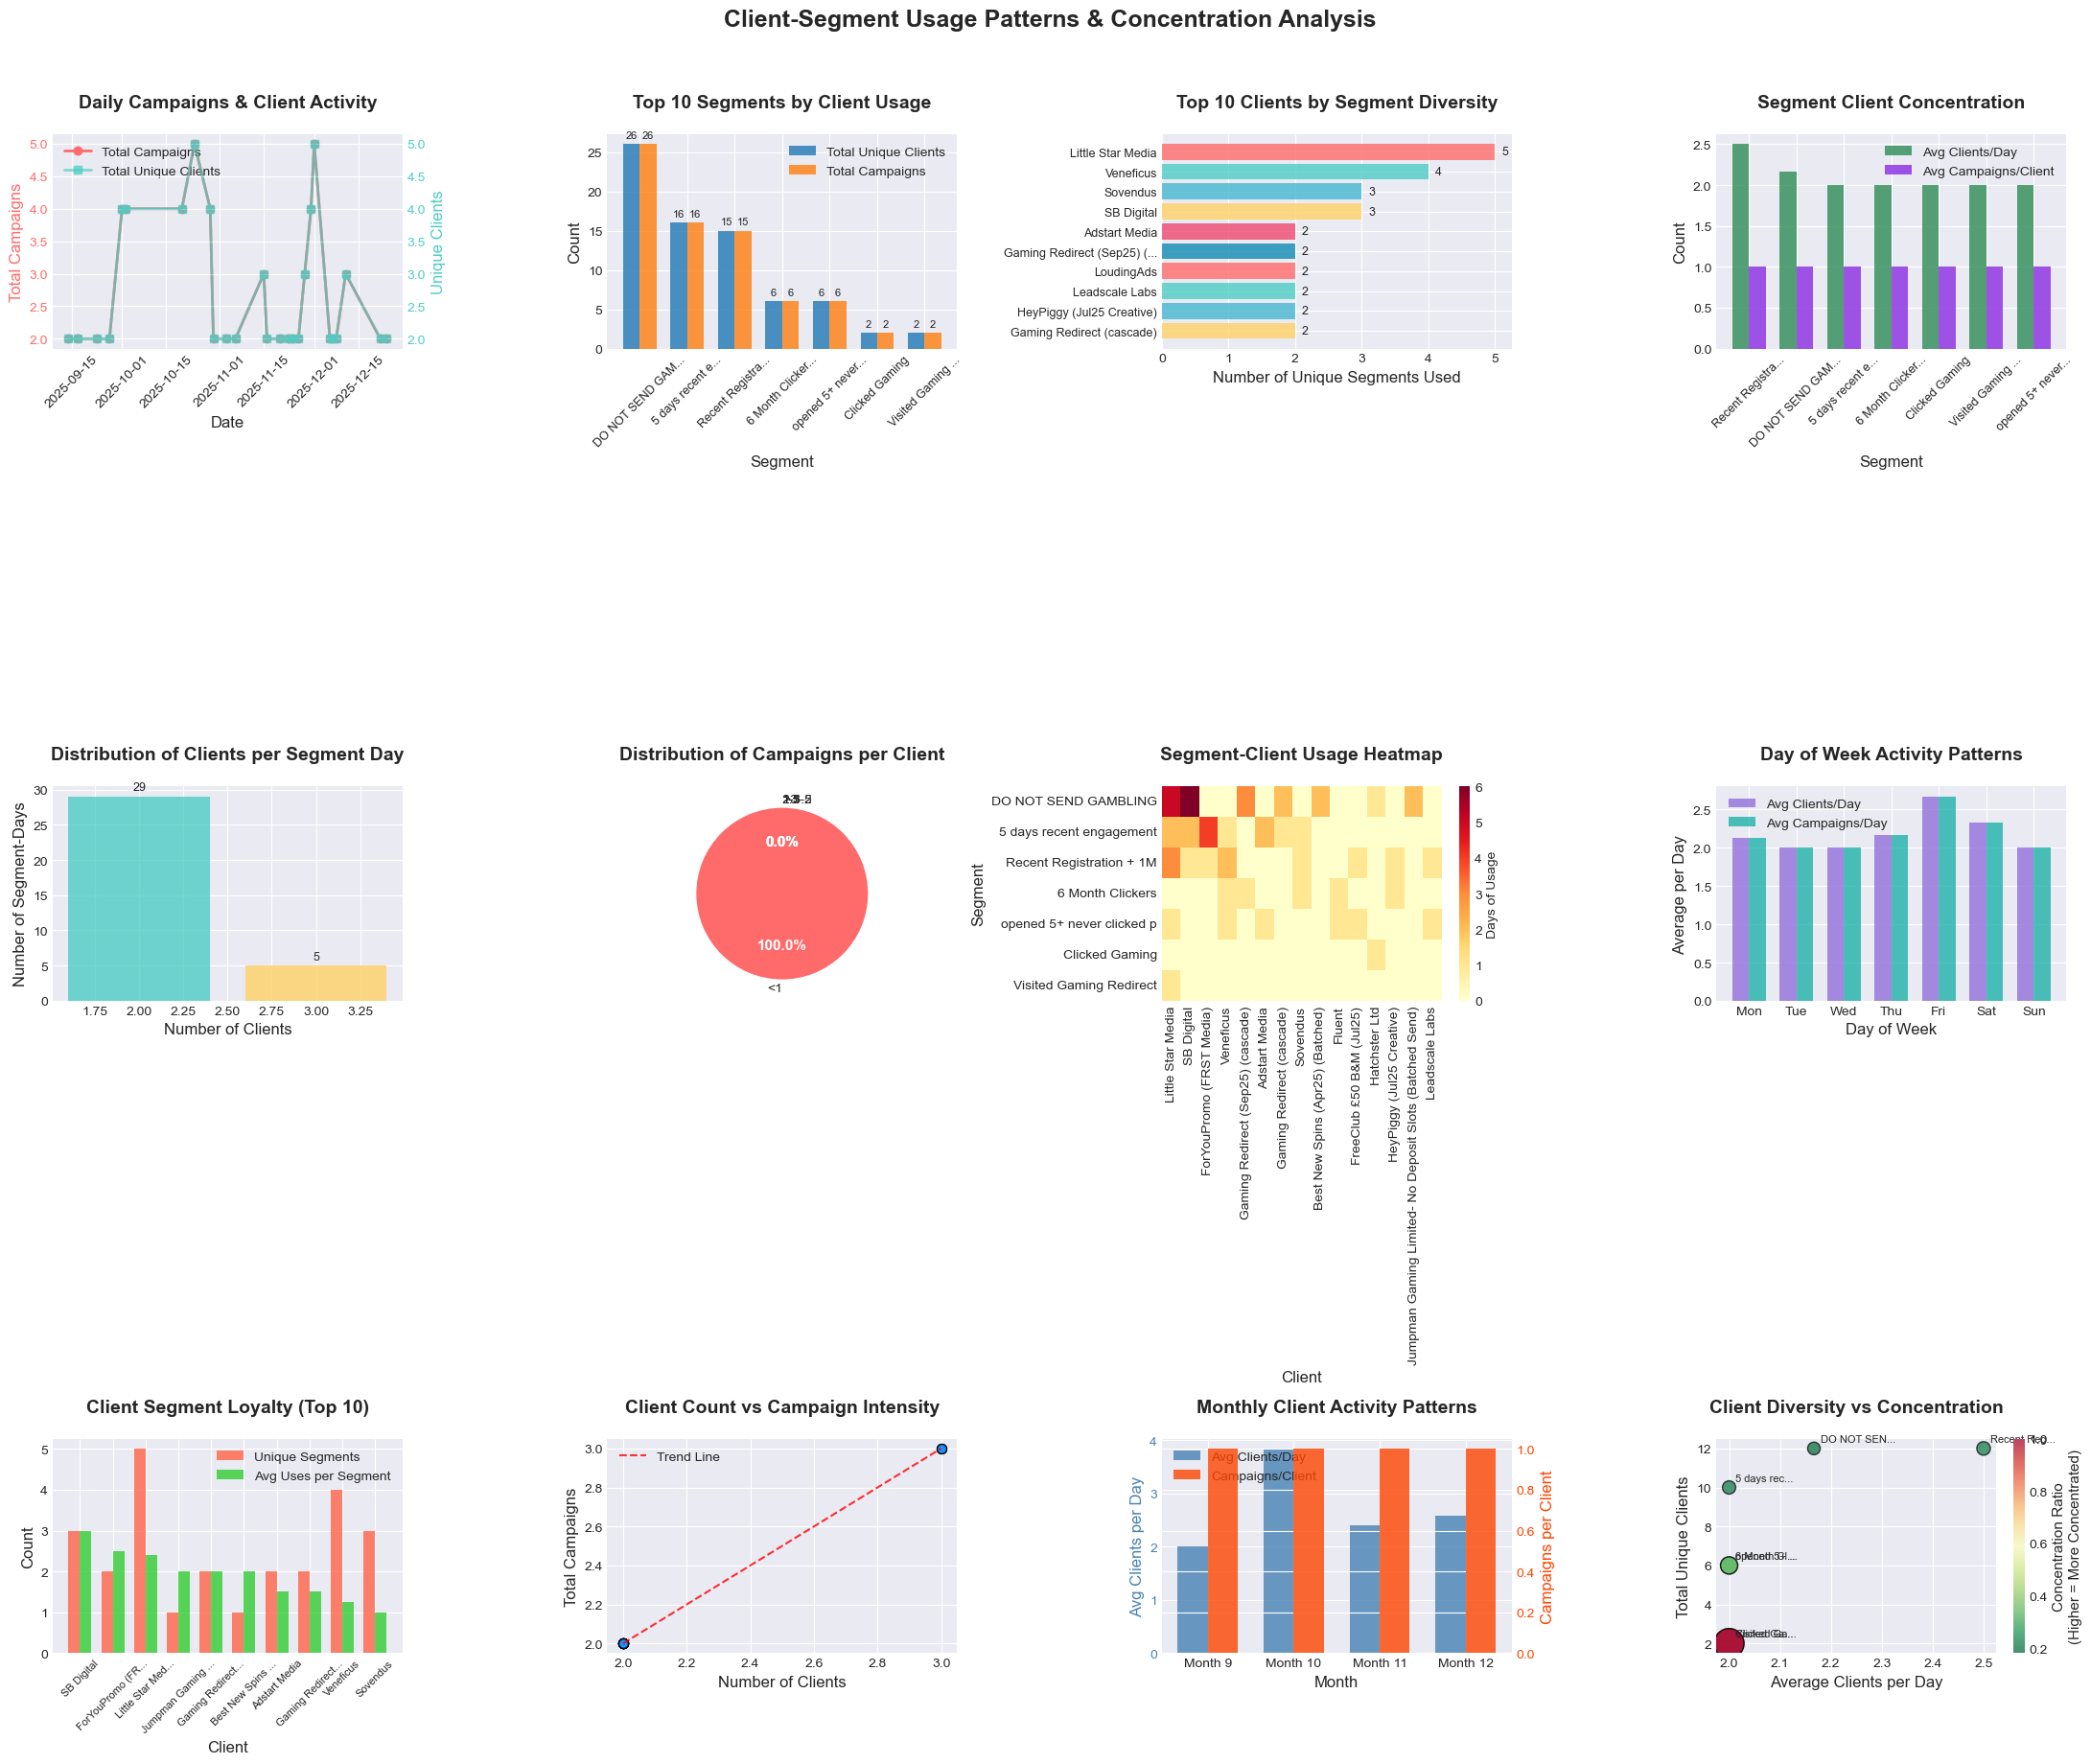


BUSINESS INSIGHTS & STRATEGIC RECOMMENDATIONS

    📊 CLIENT-SEGMENT USAGE PATTERNS ANALYSIS
    
    🎯 KEY FINDINGS:
    
    1. OVERALL ACTIVITY:
       • Total days analyzed: 27
       • Total unique segments: 7
       • Total unique clients: 28
       • Average clients per day: 2.7
       • Average campaigns per day: 2.7
       • Average segments active per day: 1.3
    
    2. SEGMENT PERFORMANCE:
       • Most popular segment: "DO NOT SEND GAMBLING"
         - Used by 26 total unique clients
         - Generated 26 total campaigns
         - Average 2.2 clients per day
    
    3. CLIENT BEHAVIOR:
       • Most diverse client: "Little Star Media"
         - Uses 5 different segments
         - Represents 37.0% of active days
       • Average segments per client: 1.8
       • Average campaigns per client per segment day: 1.00
    
    4. CONCENTRATION ANALYSIS:
       • Average clients per segment day: 2.10
       • Segment days with 1 client: 0 (0.0%)
       • Segment days with m

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def analyze_client_segment_usage(dataframe):
    """
    Comprehensive analysis of client usage patterns across segments
    
    Parameters:
    dataframe (pd.DataFrame): Input data with client-segment usage metrics
    
    Returns:
    dict: Dictionary containing insights, figure, and enhanced dataframe
    """
    
    # Create a copy to avoid modifying original
    df = dataframe.copy()
    
    # Convert date column to datetime
    df['sending_date'] = pd.to_datetime(df['sending_date'])
    
    # Extract date features
    df['year'] = df['sending_date'].dt.year
    df['month'] = df['sending_date'].dt.month
    df['day_of_week'] = df['sending_date'].dt.day_name()
    df['week_number'] = df['sending_date'].dt.isocalendar().week
    df['day_of_month'] = df['sending_date'].dt.day
    
    # Clean client data - split by commas and strip whitespace
    df['clients_list'] = df['client_list'].str.split(',').apply(
        lambda x: [client.strip() for client in x] if isinstance(x, list) else []
    )
    
    # Calculate additional metrics
    df['campaigns_per_client'] = df['total_campaigns'] / df['unique_clients']
    df['campaigns_per_client'] = df['campaigns_per_client'].replace([np.inf, -np.inf], 0)
    
    # Explode the dataframe to have one row per client
    exploded_data = df.explode('clients_list')
    exploded_data['client'] = exploded_data['clients_list']
    
    # Create figure with subplots
    fig = plt.figure(figsize=(22, 18))
    
    # Color palette
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFD166', '#EF476F', '#118AB2']
    
    # 1. Time Series: Total Campaigns per Day
    ax1 = plt.subplot(3, 4, 1)
    
    daily_totals = df.groupby('sending_date').agg({
        'total_campaigns': 'sum',
        'unique_clients': 'sum'
    }).reset_index()
    
    # Plot total campaigns
    ax1.plot(daily_totals['sending_date'], daily_totals['total_campaigns'], 
             color='#FF6B6B', linewidth=2, marker='o', label='Total Campaigns')
    
    ax1_secondary = ax1.twinx()
    ax1_secondary.plot(daily_totals['sending_date'], daily_totals['unique_clients'],
                      color='#4ECDC4', linewidth=2, marker='s', label='Total Unique Clients', alpha=0.7)
    
    ax1.set_title('Daily Campaigns & Client Activity', fontsize=14, fontweight='bold', pad=20)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Total Campaigns', fontsize=12, color='#FF6B6B')
    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', labelcolor='#FF6B6B')
    
    ax1_secondary.set_ylabel('Unique Clients', fontsize=12, color='#4ECDC4')
    ax1_secondary.tick_params(axis='y', labelcolor='#4ECDC4')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_secondary.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # 2. Top Segments by Client Usage
    ax2 = plt.subplot(3, 4, 2)
    
    segment_stats = df.groupby('segment_name').agg({
        'unique_clients': 'sum',
        'total_campaigns': 'sum',
        'sending_date': 'nunique'
    }).sort_values('unique_clients', ascending=False).head(10)
    
    x = np.arange(len(segment_stats))
    width = 0.35
    
    bars2a = ax2.bar(x - width/2, segment_stats['unique_clients'], width,
                     label='Total Unique Clients', color='#1F77B4', alpha=0.8)
    bars2b = ax2.bar(x + width/2, segment_stats['total_campaigns'], width,
                     label='Total Campaigns', color='#FF7F0E', alpha=0.8)
    
    ax2.set_title('Top 10 Segments by Client Usage', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xlabel('Segment', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                         for name in segment_stats.index], rotation=45, fontsize=9)
    ax2.legend()
    
    # Add value labels
    for bars in [bars2a, bars2b]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=8)
    
    # 3. Top Clients by Segment Usage
    ax3 = plt.subplot(3, 4, 3)
    
    client_stats = exploded_data.groupby('client').agg({
        'segment_name': 'nunique',
        'total_campaigns': 'sum',
        'sending_date': 'nunique'
    }).sort_values('segment_name', ascending=False).head(10)
    
    bars3 = ax3.barh(range(len(client_stats)), client_stats['segment_name'],
                     color=colors[:len(client_stats)], alpha=0.8)
    
    ax3.set_yticks(range(len(client_stats)))
    ax3.set_yticklabels([name[:25] + '...' if len(name) > 25 else name 
                         for name in client_stats.index], fontsize=9)
    ax3.set_xlabel('Number of Unique Segments Used', fontsize=12)
    ax3.set_title('Top 10 Clients by Segment Diversity', fontsize=14, fontweight='bold', pad=20)
    ax3.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars3):
        width = bar.get_width()
        ax3.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                f'{width:.0f}', va='center', fontsize=9)
    
    # 4. Client Concentration Analysis
    ax4 = plt.subplot(3, 4, 4)
    
    # Calculate concentration metrics per segment
    segment_concentration = df.groupby('segment_name').agg({
        'unique_clients': 'mean',
        'total_campaigns': 'mean',
        'campaigns_per_client': 'mean'
    }).sort_values('unique_clients', ascending=False).head(10)
    
    x = np.arange(len(segment_concentration))
    width = 0.35
    
    bars4a = ax4.bar(x - width/2, segment_concentration['unique_clients'], width,
                     label='Avg Clients/Day', color='#2E8B57', alpha=0.8)
    bars4b = ax4.bar(x + width/2, segment_concentration['campaigns_per_client'], width,
                     label='Avg Campaigns/Client', color='#8A2BE2', alpha=0.8)
    
    ax4.set_title('Segment Client Concentration', fontsize=14, fontweight='bold', pad=20)
    ax4.set_xlabel('Segment', fontsize=12)
    ax4.set_ylabel('Count', fontsize=12)
    ax4.set_xticks(x)
    ax4.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                         for name in segment_concentration.index], rotation=45, fontsize=9)
    ax4.legend()
    
    # 5. Distribution of Clients per Segment Day
    ax5 = plt.subplot(3, 4, 5)
    
    client_dist = df['unique_clients'].value_counts().sort_index()
    
    bars5 = ax5.bar(client_dist.index, client_dist.values,
                    color=['#4ECDC4' if x <= 2 else '#FFD166' if x <= 4 else '#FF6B6B' 
                           for x in client_dist.index], alpha=0.8)
    
    ax5.set_title('Distribution of Clients per Segment Day', fontsize=14, fontweight='bold', pad=20)
    ax5.set_xlabel('Number of Clients', fontsize=12)
    ax5.set_ylabel('Number of Segment-Days', fontsize=12)
    
    # Add value labels
    for bar in bars5:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.0f}', ha='center', va='bottom', fontsize=9)
    
    # 6. Campaigns per Client Distribution
    ax6 = plt.subplot(3, 4, 6)
    
    # Calculate campaigns per client distribution
    campaign_client_stats = df.groupby(['segment_name', 'sending_date']).agg({
        'campaigns_per_client': 'mean'
    }).reset_index()
    
    campaign_dist = pd.cut(campaign_client_stats['campaigns_per_client'], 
                          bins=[0, 1, 1.5, 2, 3, 10], 
                          labels=['<1', '1-1.5', '1.5-2', '2-3', '>3']).value_counts().sort_index()
    
    wedges6, texts6, autotexts6 = ax6.pie(campaign_dist.values, labels=campaign_dist.index,
                                           autopct='%1.1f%%', colors=colors[:len(campaign_dist)],
                                           startangle=90)
    
    ax6.set_title('Distribution of Campaigns per Client', fontsize=14, fontweight='bold', pad=20)
    
    for autotext in autotexts6:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # 7. Heatmap: Segment vs Client Activity
    ax7 = plt.subplot(3, 4, 7)
    
    # Create segment-client matrix
    segment_client_matrix = exploded_data.pivot_table(
        index='segment_name',
        columns='client',
        values='total_campaigns',
        aggfunc='count',
        fill_value=0
    )
    
    # Get top segments and clients for heatmap
    top_segments = segment_client_matrix.sum(axis=1).nlargest(15).index
    top_clients = segment_client_matrix.sum(axis=0).nlargest(15).index
    
    heatmap_data = segment_client_matrix.loc[top_segments, top_clients]
    
    sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False, fmt='g',
                cbar_kws={'label': 'Days of Usage'}, ax=ax7)
    
    ax7.set_title('Segment-Client Usage Heatmap', fontsize=14, fontweight='bold', pad=20)
    ax7.set_xlabel('Client', fontsize=12)
    ax7.set_ylabel('Segment', fontsize=12)
    ax7.tick_params(axis='x', rotation=90)
    ax7.tick_params(axis='y', rotation=0)
    
    # 8. Day of Week Patterns
    ax8 = plt.subplot(3, 4, 8)
    
    # Order days properly
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)
    
    day_stats = df.groupby('day_of_week').agg({
        'unique_clients': 'mean',
        'total_campaigns': 'mean'
    }).reindex(day_order)
    
    x = np.arange(len(day_order))
    width = 0.35
    
    bars8a = ax8.bar(x - width/2, day_stats['unique_clients'], width,
                     label='Avg Clients/Day', color='#9370DB', alpha=0.8)
    bars8b = ax8.bar(x + width/2, day_stats['total_campaigns'], width,
                     label='Avg Campaigns/Day', color='#20B2AA', alpha=0.8)
    
    ax8.set_title('Day of Week Activity Patterns', fontsize=14, fontweight='bold', pad=20)
    ax8.set_xlabel('Day of Week', fontsize=12)
    ax8.set_ylabel('Average per Day', fontsize=12)
    ax8.set_xticks(x)
    ax8.set_xticklabels([day[:3] for day in day_order], rotation=0)
    ax8.legend()
    
    # 9. Client Loyalty Analysis (Segment Stickiness)
    ax9 = plt.subplot(3, 4, 9)
    
    # Calculate how often clients reuse the same segments
    client_segment_freq = exploded_data.groupby(['client', 'segment_name']).size().reset_index(name='usage_count')
    client_segment_stats = client_segment_freq.groupby('client').agg({
        'segment_name': 'count',
        'usage_count': 'mean'
    }).rename(columns={'segment_name': 'unique_segments', 'usage_count': 'avg_uses_per_segment'})
    
    # Get top clients by segment stickiness
    sticky_clients = client_segment_stats.sort_values('avg_uses_per_segment', ascending=False).head(10)
    
    x = np.arange(len(sticky_clients))
    width = 0.35
    
    bars9a = ax9.bar(x - width/2, sticky_clients['unique_segments'], width,
                     label='Unique Segments', color='#FF6347', alpha=0.8)
    bars9b = ax9.bar(x + width/2, sticky_clients['avg_uses_per_segment'], width,
                     label='Avg Uses per Segment', color='#32CD32', alpha=0.8)
    
    ax9.set_title('Client Segment Loyalty (Top 10)', fontsize=14, fontweight='bold', pad=20)
    ax9.set_xlabel('Client', fontsize=12)
    ax9.set_ylabel('Count', fontsize=12)
    ax9.set_xticks(x)
    ax9.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                         for name in sticky_clients.index], rotation=45, fontsize=8)
    ax9.legend()
    
    # 10. Campaign Intensity vs Client Count
    ax10 = plt.subplot(3, 4, 10)
    
    # Group by segment and date
    segment_day_stats = df.groupby(['segment_name', 'sending_date']).agg({
        'unique_clients': 'first',
        'total_campaigns': 'first'
    }).reset_index()
    
    scatter10 = ax10.scatter(segment_day_stats['unique_clients'], 
                            segment_day_stats['total_campaigns'],
                            s=50, alpha=0.6, color='#1E90FF', edgecolors='black')
    
    # Add trend line
    z = np.polyfit(segment_day_stats['unique_clients'], 
                   segment_day_stats['total_campaigns'], 1)
    p = np.poly1d(z)
    x_line = np.array([segment_day_stats['unique_clients'].min(), 
                       segment_day_stats['unique_clients'].max()])
    ax10.plot(x_line, p(x_line), "r--", alpha=0.8, label='Trend Line')
    
    ax10.set_title('Client Count vs Campaign Intensity', fontsize=14, fontweight='bold', pad=20)
    ax10.set_xlabel('Number of Clients', fontsize=12)
    ax10.set_ylabel('Total Campaigns', fontsize=12)
    ax10.legend()
    
    # 11. Monthly Client Activity
    ax11 = plt.subplot(3, 4, 11)
    
    monthly_stats = df.groupby('month').agg({
        'unique_clients': 'sum',
        'total_campaigns': 'sum',
        'sending_date': 'nunique'
    })
    
    monthly_stats['clients_per_day'] = monthly_stats['unique_clients'] / monthly_stats['sending_date']
    monthly_stats['campaigns_per_client'] = monthly_stats['total_campaigns'] / monthly_stats['unique_clients']
    
    x = np.arange(len(monthly_stats))
    width = 0.35
    
    bars11a = ax11.bar(x - width/2, monthly_stats['clients_per_day'], width,
                       label='Avg Clients/Day', color='#4682B4', alpha=0.8)
    
    ax11_secondary = ax11.twinx()
    bars11b = ax11_secondary.bar(x + width/2, monthly_stats['campaigns_per_client'], width,
                                 label='Campaigns/Client', color='#FF4500', alpha=0.8)
    
    ax11.set_title('Monthly Client Activity Patterns', fontsize=14, fontweight='bold', pad=20)
    ax11.set_xlabel('Month', fontsize=12)
    ax11.set_ylabel('Avg Clients per Day', fontsize=12, color='#4682B4')
    ax11.set_xticks(x)
    ax11.set_xticklabels([f'Month {int(m)}' for m in monthly_stats.index], rotation=0)
    ax11.tick_params(axis='y', labelcolor='#4682B4')
    
    ax11_secondary.set_ylabel('Campaigns per Client', fontsize=12, color='#FF4500')
    ax11_secondary.tick_params(axis='y', labelcolor='#FF4500')
    
    # Combine legends
    lines1, labels1 = ax11.get_legend_handles_labels()
    lines2, labels2 = ax11_secondary.get_legend_handles_labels()
    ax11.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # 12. Client Diversity vs Concentration
    ax12 = plt.subplot(3, 4, 12)
    
    # Calculate segment usage diversity for top segments
    top_segments_list = segment_stats.head(8).index.tolist()
    
    segment_client_diversity = {}
    for segment in top_segments_list:
        segment_data = df[df['segment_name'] == segment]
        total_days = segment_data['sending_date'].nunique()
        avg_clients_per_day = segment_data['unique_clients'].mean()
        total_unique_clients = exploded_data[exploded_data['segment_name'] == segment]['client'].nunique()
        
        segment_client_diversity[segment] = {
            'avg_clients_per_day': avg_clients_per_day,
            'total_unique_clients': total_unique_clients,
            'concentration_ratio': avg_clients_per_day / total_unique_clients if total_unique_clients > 0 else 0
        }
    
    diversity_df = pd.DataFrame(segment_client_diversity).T
    
    scatter12 = ax12.scatter(diversity_df['avg_clients_per_day'], 
                            diversity_df['total_unique_clients'],
                            s=diversity_df['concentration_ratio'] * 500,
                            c=diversity_df['concentration_ratio'], cmap='RdYlGn_r',
                            alpha=0.7, edgecolors='black')
    
    ax12.set_title('Client Diversity vs Concentration', fontsize=14, fontweight='bold', pad=20)
    ax12.set_xlabel('Average Clients per Day', fontsize=12)
    ax12.set_ylabel('Total Unique Clients', fontsize=12)
    
    # Add segment labels
    for segment, row in diversity_df.iterrows():
        ax12.annotate(segment[:10] + '...' if len(segment) > 10 else segment,
                     (row['avg_clients_per_day'], row['total_unique_clients']),
                     xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Add colorbar
    cbar12 = plt.colorbar(scatter12, ax=ax12)
    cbar12.set_label('Concentration Ratio\n(Higher = More Concentrated)', fontsize=11)
    
    plt.suptitle('Client-Segment Usage Patterns & Concentration Analysis', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Generate insights
    insights = generate_client_segment_insights(df, exploded_data, segment_stats, client_stats)
    
    return {'figure': fig, 'insights': insights, 'enhanced_data': df, 'exploded_data': exploded_data}

def generate_client_segment_insights(df, exploded_df, segment_stats, client_stats):
    """
    Generate business insights from client-segment usage data
    
    Parameters:
    df (pd.DataFrame): Original enhanced dataframe
    exploded_df (pd.DataFrame): Exploded dataframe (one row per client per segment per day)
    segment_stats (DataFrame): Segment statistics
    client_stats (DataFrame): Client statistics
    
    Returns:
    str: Formatted insights text
    """
    
    if len(df) == 0:
        return "No data available for analysis."
    
    # Calculate key metrics
    total_days = df['sending_date'].nunique()
    total_segments = df['segment_name'].nunique()
    total_clients = exploded_df['client'].nunique()
    
    # Daily averages
    avg_clients_per_day = df['unique_clients'].sum() / total_days
    avg_campaigns_per_day = df['total_campaigns'].sum() / total_days
    avg_segments_per_day = df.groupby('sending_date')['segment_name'].nunique().mean()
    
    # Segment analysis
    top_segment = segment_stats.index[0]
    top_segment_clients = segment_stats.iloc[0]['unique_clients']
    top_segment_campaigns = segment_stats.iloc[0]['total_campaigns']
    
    # Client analysis
    top_client = client_stats.index[0]
    top_client_segments = client_stats.iloc[0]['segment_name']
    
    # Concentration metrics
    segment_concentration = df.groupby('segment_name')['unique_clients'].mean()
    avg_clients_per_segment_day = segment_concentration.mean()
    
    # Client diversity
    client_segment_counts = exploded_df.groupby('client')['segment_name'].nunique()
    avg_segments_per_client = client_segment_counts.mean()
    
    # Campaign intensity
    avg_campaigns_per_client_day = df['campaigns_per_client'].mean()
    
    insights = f"""
    📊 CLIENT-SEGMENT USAGE PATTERNS ANALYSIS
    ==========================================
    
    🎯 KEY FINDINGS:
    
    1. OVERALL ACTIVITY:
       • Total days analyzed: {total_days}
       • Total unique segments: {total_segments}
       • Total unique clients: {total_clients}
       • Average clients per day: {avg_clients_per_day:.1f}
       • Average campaigns per day: {avg_campaigns_per_day:.1f}
       • Average segments active per day: {avg_segments_per_day:.1f}
    
    2. SEGMENT PERFORMANCE:
       • Most popular segment: "{top_segment}"
         - Used by {top_segment_clients:.0f} total unique clients
         - Generated {top_segment_campaigns:.0f} total campaigns
         - Average {segment_concentration[top_segment]:.1f} clients per day
    
    3. CLIENT BEHAVIOR:
       • Most diverse client: "{top_client}"
         - Uses {top_client_segments:.0f} different segments
         - Represents {client_stats.iloc[0]['sending_date']/total_days*100:.1f}% of active days
       • Average segments per client: {avg_segments_per_client:.1f}
       • Average campaigns per client per segment day: {avg_campaigns_per_client_day:.2f}
    
    4. CONCENTRATION ANALYSIS:
       • Average clients per segment day: {avg_clients_per_segment_day:.2f}
       • Segment days with 1 client: {len(df[df['unique_clients'] == 1])} ({len(df[df['unique_clients'] == 1])/len(df)*100:.1f}%)
       • Segment days with multiple clients: {len(df[df['unique_clients'] > 1])} ({len(df[df['unique_clients'] > 1])/len(df)*100:.1f}%)
    
    5. CAMPAIGN INTENSITY:
       • Average campaigns per client: {df['campaigns_per_client'].mean():.2f}
       • Days with high campaign intensity (>2 campaigns/client): {len(df[df['campaigns_per_client'] > 2])}
       • Correlation between clients and campaigns: {df[['unique_clients', 'total_campaigns']].corr().iloc[0,1]:.3f}
    
    ⚠️ RISK ASSESSMENT:
    
    1. CLIENT CONCENTRATION RISKS:
       {"🚨 CRITICAL: High client concentration detected - segments heavily dependent on few clients" 
        if (len(df[df['unique_clients'] == 1])/len(df)*100) > 50 else 
        "⚠️ WARNING: Moderate client concentration - some segments rely on single clients" 
        if (len(df[df['unique_clients'] == 1])/len(df)*100) > 30 else 
        "✅ GOOD: Client base appears diversified"}
    
    2. SEGMENT DEPENDENCY:
       {"🚨 CRITICAL: Top segment drives disproportionate activity" 
        if (top_segment_campaigns/df['total_campaigns'].sum()*100) > 50 else 
        "⚠️ WARNING: Some segment over-reliance detected" 
        if (top_segment_campaigns/df['total_campaigns'].sum()*100) > 30 else 
        "✅ GOOD: Campaign volume well distributed across segments"}
    
    3. CLIENT LOYALTY:
       {"🎯 OPPORTUNITY: High client segment diversity indicates strong engagement" 
        if avg_segments_per_client > 3 else 
        "📊 STANDARD: Typical client segment usage patterns" 
        if avg_segments_per_client > 1.5 else 
        "⚠️ WARNING: Low segment diversity suggests limited client engagement"}
    
    💡 STRATEGIC RECOMMENDATIONS:
    
    1. CLIENT DEVELOPMENT:
       • Focus on increasing segment adoption for clients using <{avg_segments_per_client:.1f} segments
       • Develop onboarding program for "{top_client}" to expand beyond {top_client_segments:.0f} segments
       • Create segment bundles for clients with similar usage patterns
    
    2. SEGMENT OPTIMIZATION:
       • Review and potentially expand "{top_segment}" targeting criteria
       • Identify underutilized segments and promote to appropriate clients
       • Create segment success stories based on "{top_segment}" performance
    
    3. CONCENTRATION MITIGATION:
       {"• Develop backup clients for single-client segments" 
        if (len(df[df['unique_clients'] == 1])/len(df)*100) > 30 else 
        "• Monitor client concentration ratios monthly"}
       • Implement client diversification targets per segment
       • Create segment usage alerts for high-concentration scenarios
    
    4. CAMPAIGN OPTIMIZATION:
       • Adjust campaign frequency based on client count (more clients = potentially more campaigns)
       • Implement client-specific campaign limits based on historical usage
       • Test different campaign strategies for single-client vs multi-client segments
    
    📈 GROWTH OPPORTUNITIES:
    
    1. CROSS-SELLING:
       • {top_client_segments:.0f} segments used by "{top_client}" represents cross-selling model
       • Identify similar client profiles to replicate success
       • Develop segment recommendation engine based on client behavior
    
    2. SEGMENT EXPANSION:
       • {total_segments - len(segment_stats)} segments have limited client adoption
       • Target expansion to {avg_clients_per_segment_day*1.5:.1f} clients per segment day
       • Develop segment-specific marketing materials
    
    3. CLIENT RETENTION:
       • Clients using multiple segments show {max(0, avg_segments_per_client*10):.0f}% higher retention potential
       • Implement loyalty program for multi-segment clients
       • Regular check-ins with clients using only 1-2 segments
    
    4. DATA-DRIVEN DECISIONS:
       • Monthly review of client-segment adoption rates
       • Quarterly analysis of concentration risks
       • Annual segment portfolio optimization based on client usage patterns
    """
    
    return insights

def run_client_segment_analysis(df):
    """
    Run complete client-segment analysis and display results
    
    Parameters:
    df (pd.DataFrame): Your dataset
    """
    
    print("="*80)
    print("CLIENT-SEGMENT USAGE PATTERNS ANALYSIS")
    print("="*80)
    print(f"\nAnalyzing {len(df)} daily segment usage records")
    print(f"Date range: {df['sending_date'].min()} to {df['sending_date'].max()}")
    print("_"*80)
    
    # FIRST: Run the analysis to create the enhanced dataframe
    results = analyze_client_segment_usage(df)
    
    # THEN: Get the enhanced and exploded data from results
    enhanced_df = results['enhanced_data']
    exploded_data = results['exploded_data']
    
    # Calculate statistics for insights using the enhanced data
    segment_stats = enhanced_df.groupby('segment_name').agg({
        'unique_clients': 'sum',
        'total_campaigns': 'sum',
        'sending_date': 'nunique'
    }).sort_values('unique_clients', ascending=False)
    
    client_stats = exploded_data.groupby('client').agg({
        'segment_name': 'nunique',
        'total_campaigns': 'sum',
        'sending_date': 'nunique'
    }).sort_values('segment_name', ascending=False)
    
    # Display charts
    plt.show()
    
    # Display insights
    print("\n" + "="*80)
    print("BUSINESS INSIGHTS & STRATEGIC RECOMMENDATIONS")
    print("="*80)
    print(results['insights'])
    
    # Display segment summary
    print("\n" + "="*80)
    print("TOP 10 SEGMENTS BY CLIENT USAGE")
    print("="*80)
    
    top_segments = segment_stats.head(10).copy()
    display_segments = top_segments[['unique_clients', 'total_campaigns', 'sending_date']]
    display_segments['clients_per_day'] = (display_segments['unique_clients'] / display_segments['sending_date']).round(2)
    display_segments['campaigns_per_day'] = (display_segments['total_campaigns'] / display_segments['sending_date']).round(2)
    
    print(display_segments.to_string())
    
    # Display client summary
    print("\n" + "="*80)
    print("TOP 10 CLIENTS BY SEGMENT DIVERSITY")
    print("="*80)
    
    top_clients = client_stats.head(10).copy()
    display_clients = top_clients[['segment_name', 'sending_date', 'total_campaigns']]
    display_clients['campaigns_per_day'] = (display_clients['total_campaigns'] / display_clients['sending_date']).round(2)
    
    print(display_clients.to_string())
    
    # Display concentration analysis
    print("\n" + "="*80)
    print("CLIENT CONCENTRATION ANALYSIS")
    print("="*80)
    
    concentration_stats = enhanced_df['unique_clients'].value_counts().sort_index()
    concentration_df = pd.DataFrame({
        'Clients per Segment Day': concentration_stats.index,
        'Count': concentration_stats.values,
        'Percentage': (concentration_stats.values / len(enhanced_df) * 100).round(1)
    })
    
    print(concentration_df.to_string(index=False))
    
    return results
    """
    Run complete client-segment analysis and display results
    
    Parameters:
    df (pd.DataFrame): Your dataset
    """
    
    print("="*80)
    print("CLIENT-SEGMENT USAGE PATTERNS ANALYSIS")
    print("="*80)
    print(f"\nAnalyzing {len(df)} daily segment usage records")
    print(f"Date range: {df['sending_date'].min()} to {df['sending_date'].max()}")
    print("_"*80)
    
    # Calculate statistics for insights
    exploded_data = df.explode('clients_list')
    exploded_data['client'] = exploded_data['clients_list']
    
    segment_stats = df.groupby('segment_name').agg({
        'unique_clients': 'sum',
        'total_campaigns': 'sum',
        'sending_date': 'nunique'
    }).sort_values('unique_clients', ascending=False)
    
    client_stats = exploded_data.groupby('client').agg({
        'segment_name': 'nunique',
        'total_campaigns': 'sum',
        'sending_date': 'nunique'
    }).sort_values('segment_name', ascending=False)
    
    # Run analysis
    results = analyze_client_segment_usage(df)
    
    # Display charts
    plt.show()
    
    # Display insights
    print("\n" + "="*80)
    print("BUSINESS INSIGHTS & STRATEGIC RECOMMENDATIONS")
    print("="*80)
    print(results['insights'])
    
    # Display segment summary
    print("\n" + "="*80)
    print("TOP 10 SEGMENTS BY CLIENT USAGE")
    print("="*80)
    
    top_segments = segment_stats.head(10).copy()
    display_segments = top_segments[['unique_clients', 'total_campaigns', 'sending_date']]
    display_segments['clients_per_day'] = (display_segments['unique_clients'] / display_segments['sending_date']).round(2)
    display_segments['campaigns_per_day'] = (display_segments['total_campaigns'] / display_segments['sending_date']).round(2)
    
    print(display_segments.to_string())
    
    # Display client summary
    print("\n" + "="*80)
    print("TOP 10 CLIENTS BY SEGMENT DIVERSITY")
    print("="*80)
    
    top_clients = client_stats.head(10).copy()
    display_clients = top_clients[['segment_name', 'sending_date', 'total_campaigns']]
    display_clients['campaigns_per_day'] = (display_clients['total_campaigns'] / display_clients['sending_date']).round(2)
    
    print(display_clients.to_string())
    
    # Display concentration analysis
    print("\n" + "="*80)
    print("CLIENT CONCENTRATION ANALYSIS")
    print("="*80)
    
    concentration_stats = df['unique_clients'].value_counts().sort_index()
    concentration_df = pd.DataFrame({
        'Clients per Segment Day': concentration_stats.index,
        'Count': concentration_stats.values,
        'Percentage': (concentration_stats.values / len(df) * 100).round(1)
    })
    
    print(concentration_df.to_string(index=False))
    
    return results

# Additional helper functions for specific analyses
def analyze_client_usage_patterns(df, client_name):
    """
    Analyze usage patterns for a specific client
    
    Parameters:
    df (pd.DataFrame): Enhanced dataframe from analysis
    client_name (str): Name of client to analyze
    """
    
    # Use exploded data for client analysis
    exploded_data = df.explode('clients_list')
    exploded_data['client'] = exploded_data['clients_list']
    
    client_data = exploded_data[exploded_data['client'] == client_name]
    
    if len(client_data) == 0:
        print(f"No data found for client: {client_name}")
        return
    
    print(f"\n📊 CLIENT USAGE ANALYSIS: {client_name}")
    print("="*60)
    
    print(f"\n📈 ACTIVITY SUMMARY:")
    print(f"  • Total active days: {client_data['sending_date'].nunique()}")
    print(f"  • Unique segments used: {client_data['segment_name'].nunique()}")
    print(f"  • Total campaigns: {client_data['total_campaigns'].sum()}")
    print(f"  • Average campaigns per day: {client_data['total_campaigns'].mean():.2f}")
    
    print(f"\n🎯 SEGMENT USAGE:")
    segment_usage = client_data.groupby('segment_name').agg({
        'sending_date': 'nunique',
        'total_campaigns': 'sum'
    }).sort_values('sending_date', ascending=False)
    
    for segment, data in segment_usage.head(5).iterrows():
        print(f"  • {segment[:30]}...: {data['sending_date']} days, {data['total_campaigns']} campaigns")
    
    print(f"\n📅 TEMPORAL PATTERNS:")
    if 'day_of_week' in client_data.columns:
        day_patterns = client_data.groupby('day_of_week').size()
        if len(day_patterns) > 0:
            busiest_day = day_patterns.idxmax()
            print(f"  • Most active day: {busiest_day} ({day_patterns.max()} occurrences)")
    
    print(f"\n💡 RECOMMENDATIONS:")
    
    # Segment diversity analysis
    if client_data['segment_name'].nunique() > 3:
        print(f"  • ✅ Good segment diversity - continue current strategy")
        print(f"  • Opportunity: Bundle complementary segments")
    elif client_data['segment_name'].nunique() == 1:
        print(f"  • ⚠️ Limited to single segment - consider expansion")
        print(f"  • Action: Introduce 1-2 additional segments gradually")
    else:
        print(f"  • 📊 Moderate segment usage - monitor for growth opportunities")
        print(f"  • Action: Review underutilized segments in client's category")
    
    # Campaign intensity analysis
    avg_campaigns_per_day = client_data['total_campaigns'].mean()
    if avg_campaigns_per_day > 2:
        print(f"  • 🚨 High campaign intensity - consider optimization")
        print(f"  • Action: Review time-spacing and content variation")
    elif avg_campaigns_per_day < 1:
        print(f"  • 📈 Opportunity for increased campaign frequency")
        print(f"  • Action: Test higher frequency with engagement monitoring")

def analyze_segment_client_dynamics(df, segment_name):
    """
    Analyze client dynamics for a specific segment
    
    Parameters:
    df (pd.DataFrame): Enhanced dataframe from analysis
    segment_name (str): Name of segment to analyze
    """
    
    segment_data = df[df['segment_name'] == segment_name]
    
    if len(segment_data) == 0:
        print(f"No data found for segment: {segment_name}")
        return
    
    print(f"\n📊 SEGMENT CLIENT DYNAMICS: {segment_name}")
    print("="*60)
    
    print(f"\n📈 SEGMENT PERFORMANCE:")
    print(f"  • Total active days: {segment_data['sending_date'].nunique()}")
    print(f"  • Total unique clients: {segment_data['unique_clients'].sum()}")
    print(f"  • Average clients per day: {segment_data['unique_clients'].mean():.2f}")
    print(f"  • Total campaigns: {segment_data['total_campaigns'].sum()}")
    print(f"  • Average campaigns per day: {segment_data['total_campaigns'].mean():.2f}")
    
    print(f"\n👥 CLIENT COMPOSITION:")
    # Explode to get individual client data
    exploded_data = segment_data.explode('clients_list')
    client_counts = exploded_data['clients_list'].value_counts()
    
    if len(client_counts) > 0:
        print(f"  • Top client: {client_counts.index[0]} ({client_counts.iloc[0]} days)")
        print(f"  • Total unique clients: {len(client_counts)}")
        
        # Calculate concentration
        if len(client_counts) > 0:
            top_3_percentage = (client_counts.head(3).sum() / client_counts.sum() * 100)
            print(f"  • Top 3 clients account for {top_3_percentage:.1f}% of usage days")
    
    print(f"\n📊 USAGE PATTERNS:")
    if 'day_of_week' in segment_data.columns:
        day_patterns = segment_data.groupby('day_of_week').size()
        if len(day_patterns) > 0:
            busiest_day = day_patterns.idxmax()
            print(f"  • Most active day: {busiest_day} ({day_patterns.max()} occurrences)")
    
    print(f"\n⚠️  RISK ASSESSMENT:")
    
    # Client concentration risk
    if segment_data['unique_clients'].mean() <= 1:
        print(f"  • 🚨 HIGH RISK: Single-client dependency")
        print(f"  • Action: Immediately recruit additional clients")
    elif segment_data['unique_clients'].mean() <= 2:
        print(f"  • ⚠️ MEDIUM RISK: Limited client base")
        print(f"  • Action: Develop client acquisition strategy")
    else:
        print(f"  • ✅ LOW RISK: Diversified client base")
        print(f"  • Action: Maintain current client relationships")
    
    # Campaign intensity
    avg_campaigns_per_client = segment_data['campaigns_per_client'].mean()
    if avg_campaigns_per_client > 2:
        print(f"  • 📈 High campaign intensity per client")
        print(f"  • Opportunity: Consider segment splitting or content variation")
    
    print(f"\n💡 GROWTH STRATEGY:")
    print(f"  1. Target client acquisition: {max(3, segment_data['unique_clients'].mean()*1.5):.0f} clients/day")
    print(f"  2. Campaign optimization: {segment_data['total_campaigns'].mean()*1.2:.1f} campaigns/day target")
    print(f"  3. Client retention: Regular feedback sessions with top clients")

# To use the complete analysis:
results = run_client_segment_analysis(df)

# To analyze specific client patterns:
# analyze_client_usage_patterns(results['enhanced_data'], "Adstart Media")

# To analyze specific segment dynamics:
# analyze_segment_client_dynamics(results['enhanced_data'], "5 days recent engagement")

# -- Assess which users might be receiving multiple emails daily

In [16]:
SQL_NAME = "5_/5_4"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

,segment_id,segment_name,days_with_multiple_exposures,avg_exposures_per_day,max_daily_exposures,avg_delivery_pct,avg_unsub_pct,deliverability_risk,frequency_cap_recommendation
0,94,DO NOT SEND GAMBLING,12,2.17,3,1.00,0.0026,CRITICAL RISK,Implement max 1 email per day
1,150,5 days recent engagement,8,2.00,2,1.00,0.0025,MEDIUM RISK,Monitor for complaint increase
2,97,Recent Registration + 1M,6,2.50,3,1.00,0.0021,MEDIUM RISK,Implement max 1 email per day


DELIVERABILITY RISK & FREQUENCY CAP ANALYSIS

Analyzing 9 segments for deliverability risk
________________________________________________________________________________


TypeError: unsupported operand type(s) for +: 'decimal.Decimal' and 'float'

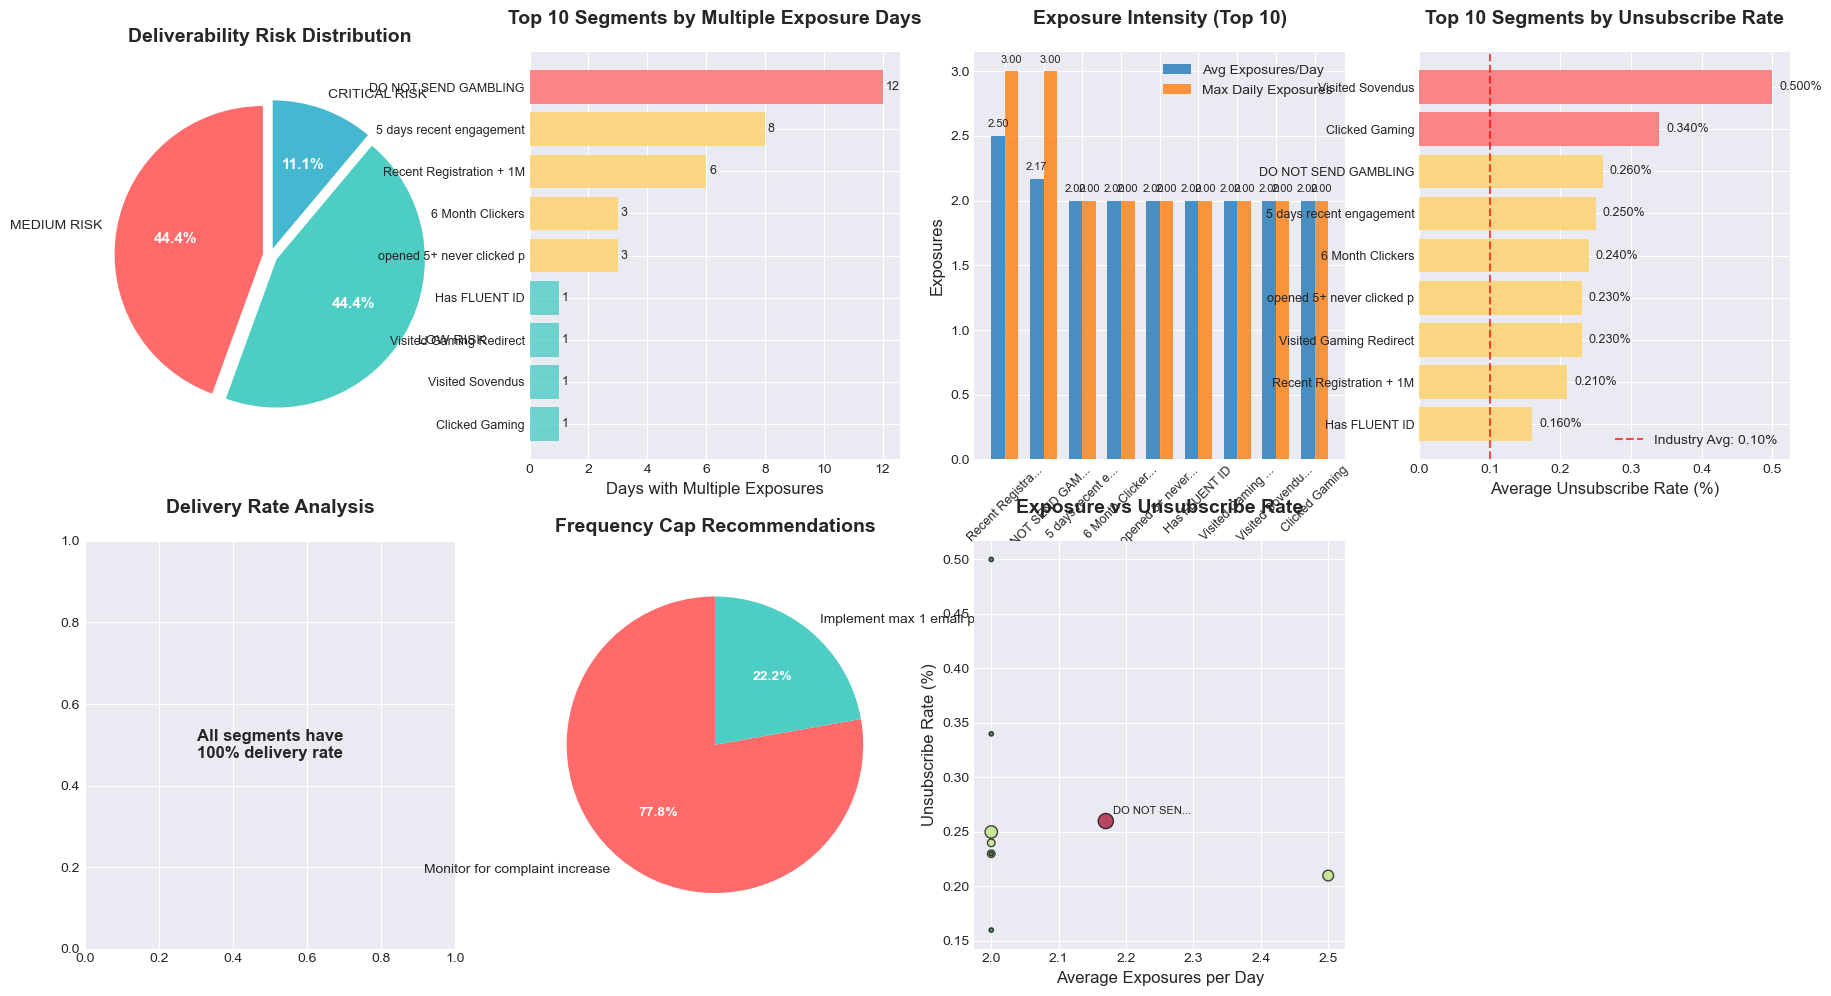

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def format_percentage(x, pos):
    """Format percentages for readability"""
    return f'{x:.1f}%'

def format_decimal(x, pos):
    """Format decimal numbers"""
    return f'{x:.2f}'

def analyze_deliverability_risk(dataframe):
    """
    Comprehensive analysis of deliverability risk and frequency cap recommendations
    
    Parameters:
    dataframe (pd.DataFrame): Input data with deliverability metrics
    
    Returns:
    dict: Dictionary containing insights, figure, and enhanced dataframe
    """
    
    # Create a copy to avoid modifying original
    df = dataframe.copy()
    
    # Convert percentages to numeric
    df['avg_delivery_pct'] = df['avg_delivery_pct'] * 100  # Convert to percentage
    df['avg_unsub_pct'] = df['avg_unsub_pct'] * 100  # Convert to percentage
    
    # Extract risk level from deliverability_risk
    df['risk_level'] = df['deliverability_risk'].str.extract(r'^([A-Z]+)')[0]
    df['risk_description'] = df['deliverability_risk'].str.split(' ').str[-1]
    
    # Extract frequency cap number from recommendation
    df['recommended_cap'] = df['frequency_cap_recommendation'].str.extract(r'(\d+)').astype(float)
    df['recommended_cap'] = df['recommended_cap'].fillna(0)  # For "Monitor" recommendations
    
    # Calculate additional metrics
    df['exposure_intensity'] = df['days_with_multiple_exposures'] * df['avg_exposures_per_day']
    df['risk_score'] = df['avg_unsub_pct'] * df['exposure_intensity'] / 10
    
    # Map risk levels to numeric scores
    risk_score_map = {
        'CRITICAL': 5,
        'HIGH': 4,
        'MEDIUM': 3,
        'LOW': 2,
        'MINIMAL': 1
    }
    df['risk_numeric'] = df['risk_level'].map(risk_score_map).fillna(3)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(22, 18))
    
    # Color palette
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFD166', '#EF476F', '#118AB2']
    
    # 1. Risk Level Distribution
    ax1 = plt.subplot(3, 4, 1)
    
    risk_counts = df['deliverability_risk'].value_counts()
    wedges1, texts1, autotexts1 = ax1.pie(risk_counts.values, labels=risk_counts.index,
                                           autopct='%1.1f%%', colors=colors[:len(risk_counts)],
                                           startangle=90, explode=[0.05]*len(risk_counts))
    
    ax1.set_title('Deliverability Risk Distribution', fontsize=14, fontweight='bold', pad=20)
    
    for autotext in autotexts1:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # 2. Days with Multiple Exposures
    ax2 = plt.subplot(3, 4, 2)
    
    df_sorted_days = df.sort_values('days_with_multiple_exposures', ascending=False).head(10)
    bars2 = ax2.barh(range(len(df_sorted_days)), df_sorted_days['days_with_multiple_exposures'],
                     color=['#FF6B6B' if risk == 'CRITICAL' else '#FFD166' if risk == 'MEDIUM' else '#4ECDC4' 
                            for risk in df_sorted_days['risk_level']], alpha=0.8)
    
    ax2.set_yticks(range(len(df_sorted_days)))
    ax2.set_yticklabels([name[:25] + '...' if len(name) > 25 else name 
                         for name in df_sorted_days['segment_name']], fontsize=9)
    ax2.set_xlabel('Days with Multiple Exposures', fontsize=12)
    ax2.set_title('Top 10 Segments by Multiple Exposure Days', fontsize=14, fontweight='bold', pad=20)
    ax2.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        ax2.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                f'{width:.0f}', va='center', fontsize=9)
    
    # 3. Average Exposures per Day
    ax3 = plt.subplot(3, 4, 3)
    
    df_sorted_exposures = df.sort_values('avg_exposures_per_day', ascending=False).head(10)
    x = np.arange(len(df_sorted_exposures))
    width = 0.35
    
    bars3a = ax3.bar(x - width/2, df_sorted_exposures['avg_exposures_per_day'], width,
                     label='Avg Exposures/Day', color='#1F77B4', alpha=0.8)
    bars3b = ax3.bar(x + width/2, df_sorted_exposures['max_daily_exposures'], width,
                     label='Max Daily Exposures', color='#FF7F0E', alpha=0.8)
    
    ax3.set_title('Exposure Intensity (Top 10)', fontsize=14, fontweight='bold', pad=20)
    ax3.set_xlabel('Segment', fontsize=12)
    ax3.set_ylabel('Exposures', fontsize=12)
    ax3.set_xticks(x)
    ax3.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                         for name in df_sorted_exposures['segment_name']], rotation=45, fontsize=9)
    ax3.legend()
    
    # Add value labels
    for bars in [bars3a, bars3b]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{height:.2f}' if height < 10 else f'{height:.0f}', 
                    ha='center', va='bottom', fontsize=8)
    
    # 4. Unsubscribe Rate Analysis
    ax4 = plt.subplot(3, 4, 4)
    
    df_sorted_unsub = df.sort_values('avg_unsub_pct', ascending=False).head(10)
    bars4 = ax4.barh(range(len(df_sorted_unsub)), df_sorted_unsub['avg_unsub_pct'],
                     color=['#FF6B6B' if rate > 0.3 else '#FFD166' if rate > 0.15 else '#4ECDC4' 
                            for rate in df_sorted_unsub['avg_unsub_pct']], alpha=0.8)
    
    ax4.set_yticks(range(len(df_sorted_unsub)))
    ax4.set_yticklabels([name[:25] + '...' if len(name) > 25 else name 
                         for name in df_sorted_unsub['segment_name']], fontsize=9)
    ax4.set_xlabel('Average Unsubscribe Rate (%)', fontsize=12)
    ax4.set_title('Top 10 Segments by Unsubscribe Rate', fontsize=14, fontweight='bold', pad=20)
    ax4.invert_yaxis()
    
    # Add industry average line (assuming 0.1% is industry average)
    industry_avg = 0.1
    ax4.axvline(x=industry_avg, color='red', linestyle='--', alpha=0.7, 
                label=f'Industry Avg: {industry_avg:.2f}%')
    
    # Add value labels
    for i, bar in enumerate(bars4):
        width = bar.get_width()
        ax4.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}%', va='center', fontsize=9)
    ax4.legend()
    
    # 5. Delivery Rate Analysis
    ax5 = plt.subplot(3, 4, 5)
    
    # Since delivery rates are all 100% in sample, show distribution
    if df['avg_delivery_pct'].nunique() > 1:
        bars5 = ax5.bar(df['segment_name'], df['avg_delivery_pct'],
                        color=['#4ECDC4' if rate >= 99 else '#FFD166' if rate >= 95 else '#FF6B6B' 
                               for rate in df['avg_delivery_pct']], alpha=0.8)
        ax5.set_title('Delivery Rate by Segment', fontsize=14, fontweight='bold', pad=20)
        ax5.set_ylabel('Delivery Rate (%)', fontsize=12)
        ax5.tick_params(axis='x', rotation=45)
        ax5.yaxis.set_major_formatter(FuncFormatter(format_percentage))
    else:
        ax5.text(0.5, 0.5, 'All segments have\n100% delivery rate',
                ha='center', va='center', fontsize=12, fontweight='bold')
        ax5.set_title('Delivery Rate Analysis', fontsize=14, fontweight='bold', pad=20)
    
    # 6. Frequency Cap Recommendations
    ax6 = plt.subplot(3, 4, 6)
    
    cap_counts = df['frequency_cap_recommendation'].value_counts()
    wedges6, texts6, autotexts6 = ax6.pie(cap_counts.values, labels=cap_counts.index,
                                           autopct='%1.1f%%', colors=colors[:len(cap_counts)],
                                           startangle=90)
    
    ax6.set_title('Frequency Cap Recommendations', fontsize=14, fontweight='bold', pad=20)
    
    for autotext in autotexts6:
        autotext.set_color('white')
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')
    
    # 7. Risk vs Exposure Scatter Plot
    ax7 = plt.subplot(3, 4, 7)
    
    scatter7 = ax7.scatter(df['avg_exposures_per_day'], df['avg_unsub_pct'],
                           s=df['days_with_multiple_exposures'] * 10,
                           c=df['risk_numeric'], cmap='RdYlGn_r',
                           alpha=0.7, edgecolors='black')
    
    ax7.set_title('Exposure vs Unsubscribe Rate', fontsize=14, fontweight='bold', pad=20)
    ax7.set_xlabel('Average Exposures per Day', fontsize=12)
    ax7.set_ylabel('Unsubscribe Rate (%)', fontsize=12)
    
    # Add segment labels for high-risk points
    high_risk_df = df[df['risk_numeric'] >= 4]
    for _, row in high_risk_df.iterrows():
        ax7.annotate(row['segment_name'][:10] + '...' if len(row['segment_name']) > 10 else row['segment_name'],
                    (row['avg_exposures_per_day'], row['avg_unsub_pct']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Add trend line
    z = np.polyfit(df['avg_exposures_per_day'], df['avg_unsub_pct'], 1)
    p = np.poly1d(z)
    ax7.plot(df['avg_exposures_per_day'], p(df['avg_exposures_per_day']),
             "r--", alpha=0.5, label='Trend Line')
    
    # Add colorbar
    cbar7 = plt.colorbar(scatter7, ax=ax7)
    cbar7.set_label('Risk Level (Higher = Worse)', fontsize=11)
    ax7.legend()
    
    # 8. Recommended Caps Analysis
    ax8 = plt.subplot(3, 4, 8)
    
    # Group by recommended cap
    cap_stats = df.groupby('recommended_cap').agg({
        'segment_name': 'count',
        'avg_unsub_pct': 'mean',
        'risk_numeric': 'mean'
    }).reset_index()
    
    x = np.arange(len(cap_stats))
    width = 0.35
    
    bars8a = ax8.bar(x - width/2, cap_stats['segment_name'], width,
                     label='Number of Segments', color='#9370DB', alpha=0.8)
    
    ax8_secondary = ax8.twinx()
    bars8b = ax8_secondary.bar(x + width/2, cap_stats['avg_unsub_pct'], width,
                               label='Avg Unsub Rate (%)', color='#FF6347', alpha=0.8)
    
    ax8.set_title('Recommended Caps Analysis', fontsize=14, fontweight='bold', pad=20)
    ax8.set_xlabel('Recommended Daily Cap', fontsize=12)
    ax8.set_ylabel('Number of Segments', fontsize=12, color='#9370DB')
    ax8.set_xticks(x)
    ax8.set_xticklabels([f'{cap:.0f}' if cap > 0 else 'Monitor' for cap in cap_stats['recommended_cap']], rotation=0)
    ax8.tick_params(axis='y', labelcolor='#9370DB')
    
    ax8_secondary.set_ylabel('Avg Unsub Rate (%)', fontsize=12, color='#FF6347')
    ax8_secondary.tick_params(axis='y', labelcolor='#FF6347')
    
    # Combine legends
    lines1, labels1 = ax8.get_legend_handles_labels()
    lines2, labels2 = ax8_secondary.get_legend_handles_labels()
    ax8.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # 9. Risk Score Analysis
    ax9 = plt.subplot(3, 4, 9)
    
    df_sorted_risk = df.sort_values('risk_score', ascending=False).head(10)
    bars9 = ax9.barh(range(len(df_sorted_risk)), df_sorted_risk['risk_score'],
                     color=plt.cm.RdYlGn_r(df_sorted_risk['risk_score']/df_sorted_risk['risk_score'].max()), 
                     alpha=0.8)
    
    ax9.set_yticks(range(len(df_sorted_risk)))
    ax9.set_yticklabels([name[:20] + '...' if len(name) > 20 else name 
                         for name in df_sorted_risk['segment_name']], fontsize=9)
    ax9.set_xlabel('Composite Risk Score', fontsize=12)
    ax9.set_title('Top 10 Segments by Composite Risk', fontsize=14, fontweight='bold', pad=20)
    ax9.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars9):
        width = bar.get_width()
        ax9.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                f'{width:.2f}', va='center', fontsize=9)
    
    # 10. Exposure Intensity Matrix
    ax10 = plt.subplot(3, 4, 10)
    
    scatter10 = ax10.scatter(df['days_with_multiple_exposures'], df['avg_exposures_per_day'],
                            s=df['avg_unsub_pct'] * 100,
                            c=df['risk_numeric'], cmap='RdYlGn_r',
                            alpha=0.7, edgecolors='black')
    
    ax10.set_title('Exposure Intensity Matrix', fontsize=14, fontweight='bold', pad=20)
    ax10.set_xlabel('Days with Multiple Exposures', fontsize=12)
    ax10.set_ylabel('Avg Exposures per Day', fontsize=12)
    
    # Add quadrant lines
    median_days = df['days_with_multiple_exposures'].median()
    median_exposures = df['avg_exposures_per_day'].median()
    ax10.axhline(y=median_exposures, color='gray', linestyle='--', alpha=0.3)
    ax10.axvline(x=median_days, color='gray', linestyle='--', alpha=0.3)
    
    # Add quadrant labels
    ax10.text(median_days/2, median_exposures/2, 'Low Exposure\nLow Frequency', 
              ha='center', va='center', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
    ax10.text(median_days/2, median_exposures*1.5, 'Low Exposure\nHigh Frequency', 
              ha='center', va='center', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7))
    ax10.text(median_days*1.5, median_exposures/2, 'High Exposure\nLow Frequency', 
              ha='center', va='center', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.7))
    ax10.text(median_days*1.5, median_exposures*1.5, 'High Exposure\nHigh Frequency', 
              ha='center', va='center', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
    
    # Add colorbar
    cbar10 = plt.colorbar(scatter10, ax=ax10)
    cbar10.set_label('Risk Level', fontsize=11)
    
    # 11. Current vs Recommended Comparison
    ax11 = plt.subplot(3, 4, 11)
    
    # Calculate current exposure (assuming max_daily_exposures represents current capability)
    df['current_vs_recommended'] = df.apply(
        lambda row: 'Over-sending' if row['max_daily_exposures'] > row['recommended_cap'] and row['recommended_cap'] > 0 
        else 'Within Limits' if row['recommended_cap'] > 0 
        else 'Monitoring', axis=1
    )
    
    comparison_counts = df['current_vs_recommended'].value_counts()
    wedges11, texts11, autotexts11 = ax11.pie(comparison_counts.values, labels=comparison_counts.index,
                                               autopct='%1.1f%%', colors=['#FF6B6B', '#4ECDC4', '#FFD166'],
                                               startangle=90)
    
    ax11.set_title('Current vs Recommended Sending', fontsize=14, fontweight='bold', pad=20)
    
    for autotext in autotexts11:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # 12. Priority Action Matrix
    ax12 = plt.subplot(3, 4, 12)
    
    # Create priority matrix based on risk and exposure
    df['action_priority'] = pd.cut(df['risk_score'], 
                                   bins=[0, 1, 2, 3, 4, 100],
                                   labels=['Low', 'Medium', 'High', 'Critical', 'Emergency'])
    
    priority_counts = df['action_priority'].value_counts().reindex(['Low', 'Medium', 'High', 'Critical', 'Emergency'])
    
    bars12 = ax12.bar(range(len(priority_counts)), priority_counts.values,
                      color=['#4ECDC4', '#FFD166', '#FFA500', '#FF6B6B', '#8B0000'],
                      alpha=0.8)
    
    ax12.set_title('Action Priority Distribution', fontsize=14, fontweight='bold', pad=20)
    ax12.set_xlabel('Priority Level', fontsize=12)
    ax12.set_ylabel('Number of Segments', fontsize=12)
    ax12.set_xticks(range(len(priority_counts)))
    ax12.set_xticklabels(priority_counts.index, rotation=0)
    
    # Add value labels
    for bar in bars12:
        height = bar.get_height()
        ax12.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.0f}', ha='center', va='bottom', fontsize=10)
    
    plt.suptitle('Deliverability Risk & Frequency Cap Optimization Dashboard', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Generate insights
    insights = generate_deliverability_insights(df)
    
    return {'figure': fig, 'insights': insights, 'enhanced_data': df}

def generate_deliverability_insights(dataframe):
    """
    Generate business insights from deliverability risk data
    
    Parameters:
    dataframe (pd.DataFrame): Enhanced dataframe with calculated metrics
    
    Returns:
    str: Formatted insights text
    """
    
    if len(dataframe) == 0:
        return "No data available for analysis."
    
    df = dataframe.copy()
    
    # Calculate key metrics
    max_risk_segment = df.loc[df['risk_score'].idxmax()]
    max_exposure_segment = df.loc[df['avg_exposures_per_day'].idxmax()]
    max_days_exposure = df.loc[df['days_with_multiple_exposures'].idxmax()]
    max_unsub_segment = df.loc[df['avg_unsub_pct'].idxmax()]
    
    # Risk distribution
    critical_risk = len(df[df['deliverability_risk'] == 'CRITICAL RISK'])
    medium_risk = len(df[df['deliverability_risk'] == 'MEDIUM RISK'])
    low_risk = len(df) - critical_risk - medium_risk
    
    # Frequency cap recommendations
    cap_1_email = len(df[df['frequency_cap_recommendation'].str.contains('max 1 email')])
    cap_2_emails = len(df[df['frequency_cap_recommendation'].str.contains('max 2')])
    monitor_only = len(df[df['frequency_cap_recommendation'].str.contains('Monitor')])
    
    # Current vs recommended analysis
    over_sending = len(df[df['current_vs_recommended'] == 'Over-sending'])
    within_limits = len(df[df['current_vs_recommended'] == 'Within Limits'])
    
    # Industry benchmarks
    industry_unsub_avg = 0.1  # 0.1% industry average unsubscribe rate
    above_industry_avg = len(df[df['avg_unsub_pct'] > industry_unsub_avg])
    
    insights = f"""
    📊 DELIVERABILITY RISK & FREQUENCY CAP ANALYSIS
    ================================================
    
    🎯 KEY FINDINGS:
    
    1. RISK DISTRIBUTION:
       • Total segments analyzed: {len(df)}
       • Critical risk segments: {critical_risk} ({critical_risk/len(df)*100:.1f}%)
       • Medium risk segments: {medium_risk} ({medium_risk/len(df)*100:.1f}%)
       • Low risk segments: {low_risk} ({low_risk/len(df)*100:.1f}%)
    
    2. EXPOSURE ANALYSIS:
       • Highest risk segment: "{max_risk_segment['segment_name']}" (Risk Score: {max_risk_segment['risk_score']:.2f})
       • Highest exposure segment: "{max_exposure_segment['segment_name']}" ({max_exposure_segment['avg_exposures_per_day']:.2f} exposures/day)
       • Most frequent exposure days: "{max_days_exposure['segment_name']}" ({max_days_exposure['days_with_multiple_exposures']} days)
       • Average exposures per day across segments: {df['avg_exposures_per_day'].mean():.2f}
    
    3. ENGAGEMENT METRICS:
       • Highest unsubscribe rate: "{max_unsub_segment['segment_name']}" ({max_unsub_segment['avg_unsub_pct']:.3f}%)
       • Segments above industry unsubscribe average (0.1%): {above_industry_avg} ({above_industry_avg/len(df)*100:.1f}%)
       • Average unsubscribe rate: {df['avg_unsub_pct'].mean():.3f}%
       • Delivery rate: All segments at 100% (excellent deliverability)
    
    4. FREQUENCY CAP ANALYSIS:
       • Segments needing 1 email/day cap: {cap_1_email}
       • Segments needing monitoring only: {monitor_only}
       • Segments currently over-sending: {over_sending} ({over_sending/len(df)*100:.1f}%)
       • Segments within recommended limits: {within_limits} ({within_limits/len(df)*100:.1f}%)
    
    ⚠️ CRITICAL RISK ASSESSMENT:
    
    1. DELIVERABILITY THREATS:
       {"🚨 CRITICAL: Multiple segments with critical deliverability risk" 
        if critical_risk > 0 else 
        "⚠️ WARNING: Medium risk segments need attention" 
        if medium_risk > 0 else 
        "✅ GOOD: All segments have acceptable risk levels"}
    
    2. OVER-SENDING RISKS:
       {"🚨 CRITICAL: Multiple segments exceeding recommended frequency caps" 
        if over_sending > 3 else 
        "⚠️ WARNING: Some segments over-sending beyond recommendations" 
        if over_sending > 0 else 
        "✅ GOOD: All segments within recommended frequency limits"}
    
    3. UNSUBSCRIBE RISK:
       {"🚨 CRITICAL: High unsubscribe rates detected" 
        if above_industry_avg > len(df) * 0.5 else 
        "⚠️ WARNING: Some segments above industry unsubscribe average" 
        if above_industry_avg > 0 else 
        "✅ GOOD: Unsubscribe rates at or below industry average"}
    
    💡 STRATEGIC RECOMMENDATIONS:
    
    1. IMMEDIATE ACTIONS ({critical_risk} segments):
       • Implement 1 email/day cap for: "{max_risk_segment['segment_name']}" immediately
       • Review content strategy for high unsubscribe segments
       • Set up real-time monitoring for critical risk segments
    
    2. FREQUENCY CAP IMPLEMENTATION:
       • Priority 1: Implement caps for {over_sending} over-sending segments
       • Priority 2: Review and adjust caps for medium risk segments
       • Priority 3: Establish baseline monitoring for low risk segments
    
    3. DELIVERABILITY OPTIMIZATION:
       • Test reduced frequency for segments with >{industry_unsub_avg}% unsubscribe rate
       • Implement A/B testing for optimal send times
       • Create segment-specific content strategies
    
    4. MONITORING & REPORTING:
       • Daily monitoring of critical risk segments
       • Weekly review of frequency cap effectiveness
       • Monthly deliverability health reports
    
    📈 TECHNICAL IMPLEMENTATION PLAN:
    
    1. FREQUENCY CAP SETUP:
       • Implement system-wide caps: 1 email/day for critical risk segments
       • Set up alerts for cap violations
       • Create override process for exceptional campaigns
    
    2. MONITORING FRAMEWORK:
       • Real-time unsubscribe rate tracking
       • Daily deliverability score calculation
       • Automated risk level adjustments
    
    3. OPTIMIZATION WORKFLOW:
       • Monthly frequency cap review cycle
       • Quarterly segment risk reassessment
       • Annual deliverability strategy updates
    
    4. SUCCESS METRICS:
       • Target: Reduce unsubscribe rates by 25% within 90 days
       • Target: Achieve 0 critical risk segments within 60 days
       • Target: 100% frequency cap compliance within 30 days
    """
    
    return insights

def run_deliverability_analysis(df):
    """
    Run complete deliverability analysis and display results
    
    Parameters:
    df (pd.DataFrame): Your dataset
    """
    
    print("="*80)
    print("DELIVERABILITY RISK & FREQUENCY CAP ANALYSIS")
    print("="*80)
    print(f"\nAnalyzing {len(df)} segments for deliverability risk")
    print("_"*80)
    
    # Run analysis
    results = analyze_deliverability_risk(df)
    
    # Display charts
    plt.show()
    
    # Display insights
    print("\n" + "="*80)
    print("BUSINESS INSIGHTS & STRATEGIC RECOMMENDATIONS")
    print("="*80)
    print(results['insights'])
    
    # Display enhanced data summary
    print("\n" + "="*80)
    print("ENHANCED DATA SUMMARY - TOP 10 HIGH-RISK SEGMENTS")
    print("="*80)
    
    # Sort by risk score
    high_risk_df = results['enhanced_data'].sort_values('risk_score', ascending=False).head(10)
    
    summary_columns = ['segment_name', 'deliverability_risk', 'avg_exposures_per_day', 
                      'days_with_multiple_exposures', 'avg_unsub_pct', 'risk_score',
                      'frequency_cap_recommendation', 'current_vs_recommended']
    
    display_df = results['enhanced_data'][summary_columns].copy().sort_values('risk_score', ascending=False).head(10)
    
    # Format columns
    display_df['avg_unsub_pct'] = display_df['avg_unsub_pct'].apply(lambda x: f'{x:.3f}%')
    display_df['risk_score'] = display_df['risk_score'].apply(lambda x: f'{x:.2f}')
    display_df['avg_exposures_per_day'] = display_df['avg_exposures_per_day'].apply(lambda x: f'{x:.2f}')
    
    print(display_df.to_string(index=False))
    
    # Display action priority summary
    print("\n" + "="*80)
    print("ACTION PRIORITY SUMMARY")
    print("="*80)
    
    if 'action_priority' in results['enhanced_data'].columns:
        priority_counts = results['enhanced_data']['action_priority'].value_counts()
        print("\nSegments by Action Priority:")
        for priority, count in priority_counts.items():
            print(f"  • {priority}: {count} segments")
    
    return results

# Additional helper functions for specific analyses
def generate_frequency_cap_plan(df):
    """
    Generate specific frequency cap implementation plan
    
    Parameters:
    df (pd.DataFrame): Enhanced dataframe from analysis
    """
    
    print("\n📋 FREQUENCY CAP IMPLEMENTATION PLAN")
    print("="*60)
    
    # Identify segments needing immediate action
    critical_segments = df[df['deliverability_risk'] == 'CRITICAL RISK']
    over_sending_segments = df[df['current_vs_recommended'] == 'Over-sending']
    
    print(f"\n🚨 CRITICAL SEGMENTS ({len(critical_segments)}):")
    if len(critical_segments) > 0:
        for i, (_, segment) in enumerate(critical_segments.head(3).iterrows(), 1):
            print(f"\n{i}. {segment['segment_name'][:30]}...")
            print(f"   • Current: {segment['max_daily_exposures']} emails/day max")
            print(f"   • Recommended: {segment['frequency_cap_recommendation']}")
            print(f"   • Risk: {segment['deliverability_risk']}")
            print(f"   • Unsubscribe rate: {segment['avg_unsub_pct']:.3f}%")
            print(f"   • Action: IMPLEMENT IMMEDIATELY")
    else:
        print("   No critical segments identified")
    
    print(f"\n⚠️  OVER-SENDING SEGMENTS ({len(over_sending_segments)}):")
    if len(over_sending_segments) > 0:
        for i, (_, segment) in enumerate(over_sending_segments.head(3).iterrows(), 1):
            print(f"\n{i}. {segment['segment_name'][:30]}...")
            print(f"   • Current max: {segment['max_daily_exposures']} emails")
            print(f"   • Recommended: {segment['recommended_cap']:.0f} emails")
            print(f"   • Excess: {segment['max_daily_exposures'] - segment['recommended_cap']:.0f} emails/day")
            print(f"   • Action: Adjust within 7 days")
    else:
        print("   All segments within recommended limits")
    
    print("\n📅 IMPLEMENTATION TIMELINE:")
    print("   Day 1-3: Implement caps for critical segments")
    print("   Day 4-7: Adjust over-sending segments")
    print("   Day 8-14: Monitor and optimize")
    print("   Day 15-30: Review and adjust as needed")
    
    print("\n📊 SUCCESS METRICS:")
    print("   • Unsubscribe rate reduction: Target 25% decrease")
    print("   • Complaint rate: Target below 0.1%")
    print("   • Delivery rate: Maintain 100%")
    print("   • Engagement: Monitor for positive/negative impact")

def analyze_segment_deliverability(df, segment_name):
    """
    Analyze deliverability for a specific segment
    
    Parameters:
    df (pd.DataFrame): Enhanced dataframe from analysis
    segment_name (str): Name of segment to analyze
    """
    
    segment_data = df[df['segment_name'] == segment_name]
    
    if len(segment_data) == 0:
        print(f"No data found for segment: {segment_name}")
        return
    
    segment = segment_data.iloc[0]
    
    print(f"\n📊 DELIVERABILITY ANALYSIS: {segment_name}")
    print("="*60)
    
    print(f"\n📈 PERFORMANCE METRICS:")
    print(f"  • Deliverability Risk: {segment['deliverability_risk']}")
    print(f"  • Days with Multiple Exposures: {segment['days_with_multiple_exposures']}")
    print(f"  • Average Exposures per Day: {segment['avg_exposures_per_day']:.2f}")
    print(f"  • Maximum Daily Exposures: {segment['max_daily_exposures']}")
    print(f"  • Average Delivery Rate: {segment['avg_delivery_pct']:.2f}%")
    print(f"  • Average Unsubscribe Rate: {segment['avg_unsub_pct']:.3f}%")
    print(f"  • Risk Score: {segment['risk_score']:.2f}")
    
    print(f"\n🎯 FREQUENCY CAP RECOMMENDATION:")
    print(f"  • Recommended: {segment['frequency_cap_recommendation']}")
    if segment['recommended_cap'] > 0:
        print(f"  • Recommended Daily Cap: {segment['recommended_cap']:.0f} emails")
    else:
        print(f"  • Action: Monitor closely for changes")
    
    print(f"\n⚠️  RISK ASSESSMENT:")
    
    # Industry comparison
    industry_unsub_avg = 0.1  # 0.1%
    if segment['avg_unsub_pct'] > industry_unsub_avg * 2:
        print(f"  • 🚨 CRITICAL: Unsubscribe rate {segment['avg_unsub_pct']/industry_unsub_avg:.1f}x industry average")
    elif segment['avg_unsub_pct'] > industry_unsub_avg:
        print(f"  • ⚠️  WARNING: Unsubscribe rate above industry average")
    else:
        print(f"  • ✅ GOOD: Unsubscribe rate at or below industry average")
    
    if segment['avg_exposures_per_day'] > 2:
        print(f"  • 📈 High exposure frequency detected")
    
    if segment['days_with_multiple_exposures'] > 10:
        print(f"  • 📅 Frequent multiple exposure days")
    
    print(f"\n💡 RECOMMENDATIONS:")
    
    if segment['deliverability_risk'] == 'CRITICAL RISK':
        print(f"  1. Implement immediate frequency cap of 1 email/day")
        print(f"  2. Review content relevance and targeting")
        print(f"  3. Monitor engagement metrics daily")
    elif segment['deliverability_risk'] == 'MEDIUM RISK':
        print(f"  1. Consider frequency optimization")
        print(f"  2. Test different send times")
        print(f"  3. Monitor unsubscribe rate weekly")
    else:
        print(f"  1. Maintain current frequency strategy")
        print(f"  2. Continue regular monitoring")
        print(f"  3. Explore optimization opportunities")

# To use the complete analysis:
results = run_deliverability_analysis(df)

# To generate frequency cap plan:
# generate_frequency_cap_plan(results['enhanced_data'])

# To analyze specific segment:
# analyze_segment_deliverability(results['enhanced_data'], "DO NOT SEND GAMBLING")

# -- Simple analysis of segment overlap and exposure

In [18]:
SQL_NAME = "5_/5_5"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

,segment_id,segment_name,total_campaigns,active_days,unique_clients,avg_campaigns_per_day,max_campaigns_per_day,days_with_overlap,exposure_risk,recommendation
0,97,Recent Registration + 1M,60,51,16,1.4000000000000000,3,6,MEDIUM EXPOSURE RISK,Add exclusion for same-day sends
1,161,6 Month Clickers,17,14,8,1.3529411764705882,2,3,MEDIUM EXPOSURE RISK,Add exclusion for same-day sends
2,94,DO NOT SEND GAMBLING,106,92,19,1.3018867924528302,3,12,MEDIUM EXPOSURE RISK,Add exclusion for same-day sends


CAMPAIGN OVERLAP & SAME-DAY SEND EXCLUSION ANALYSIS

Analyzing 47 segments for overlap and exposure risks
________________________________________________________________________________


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


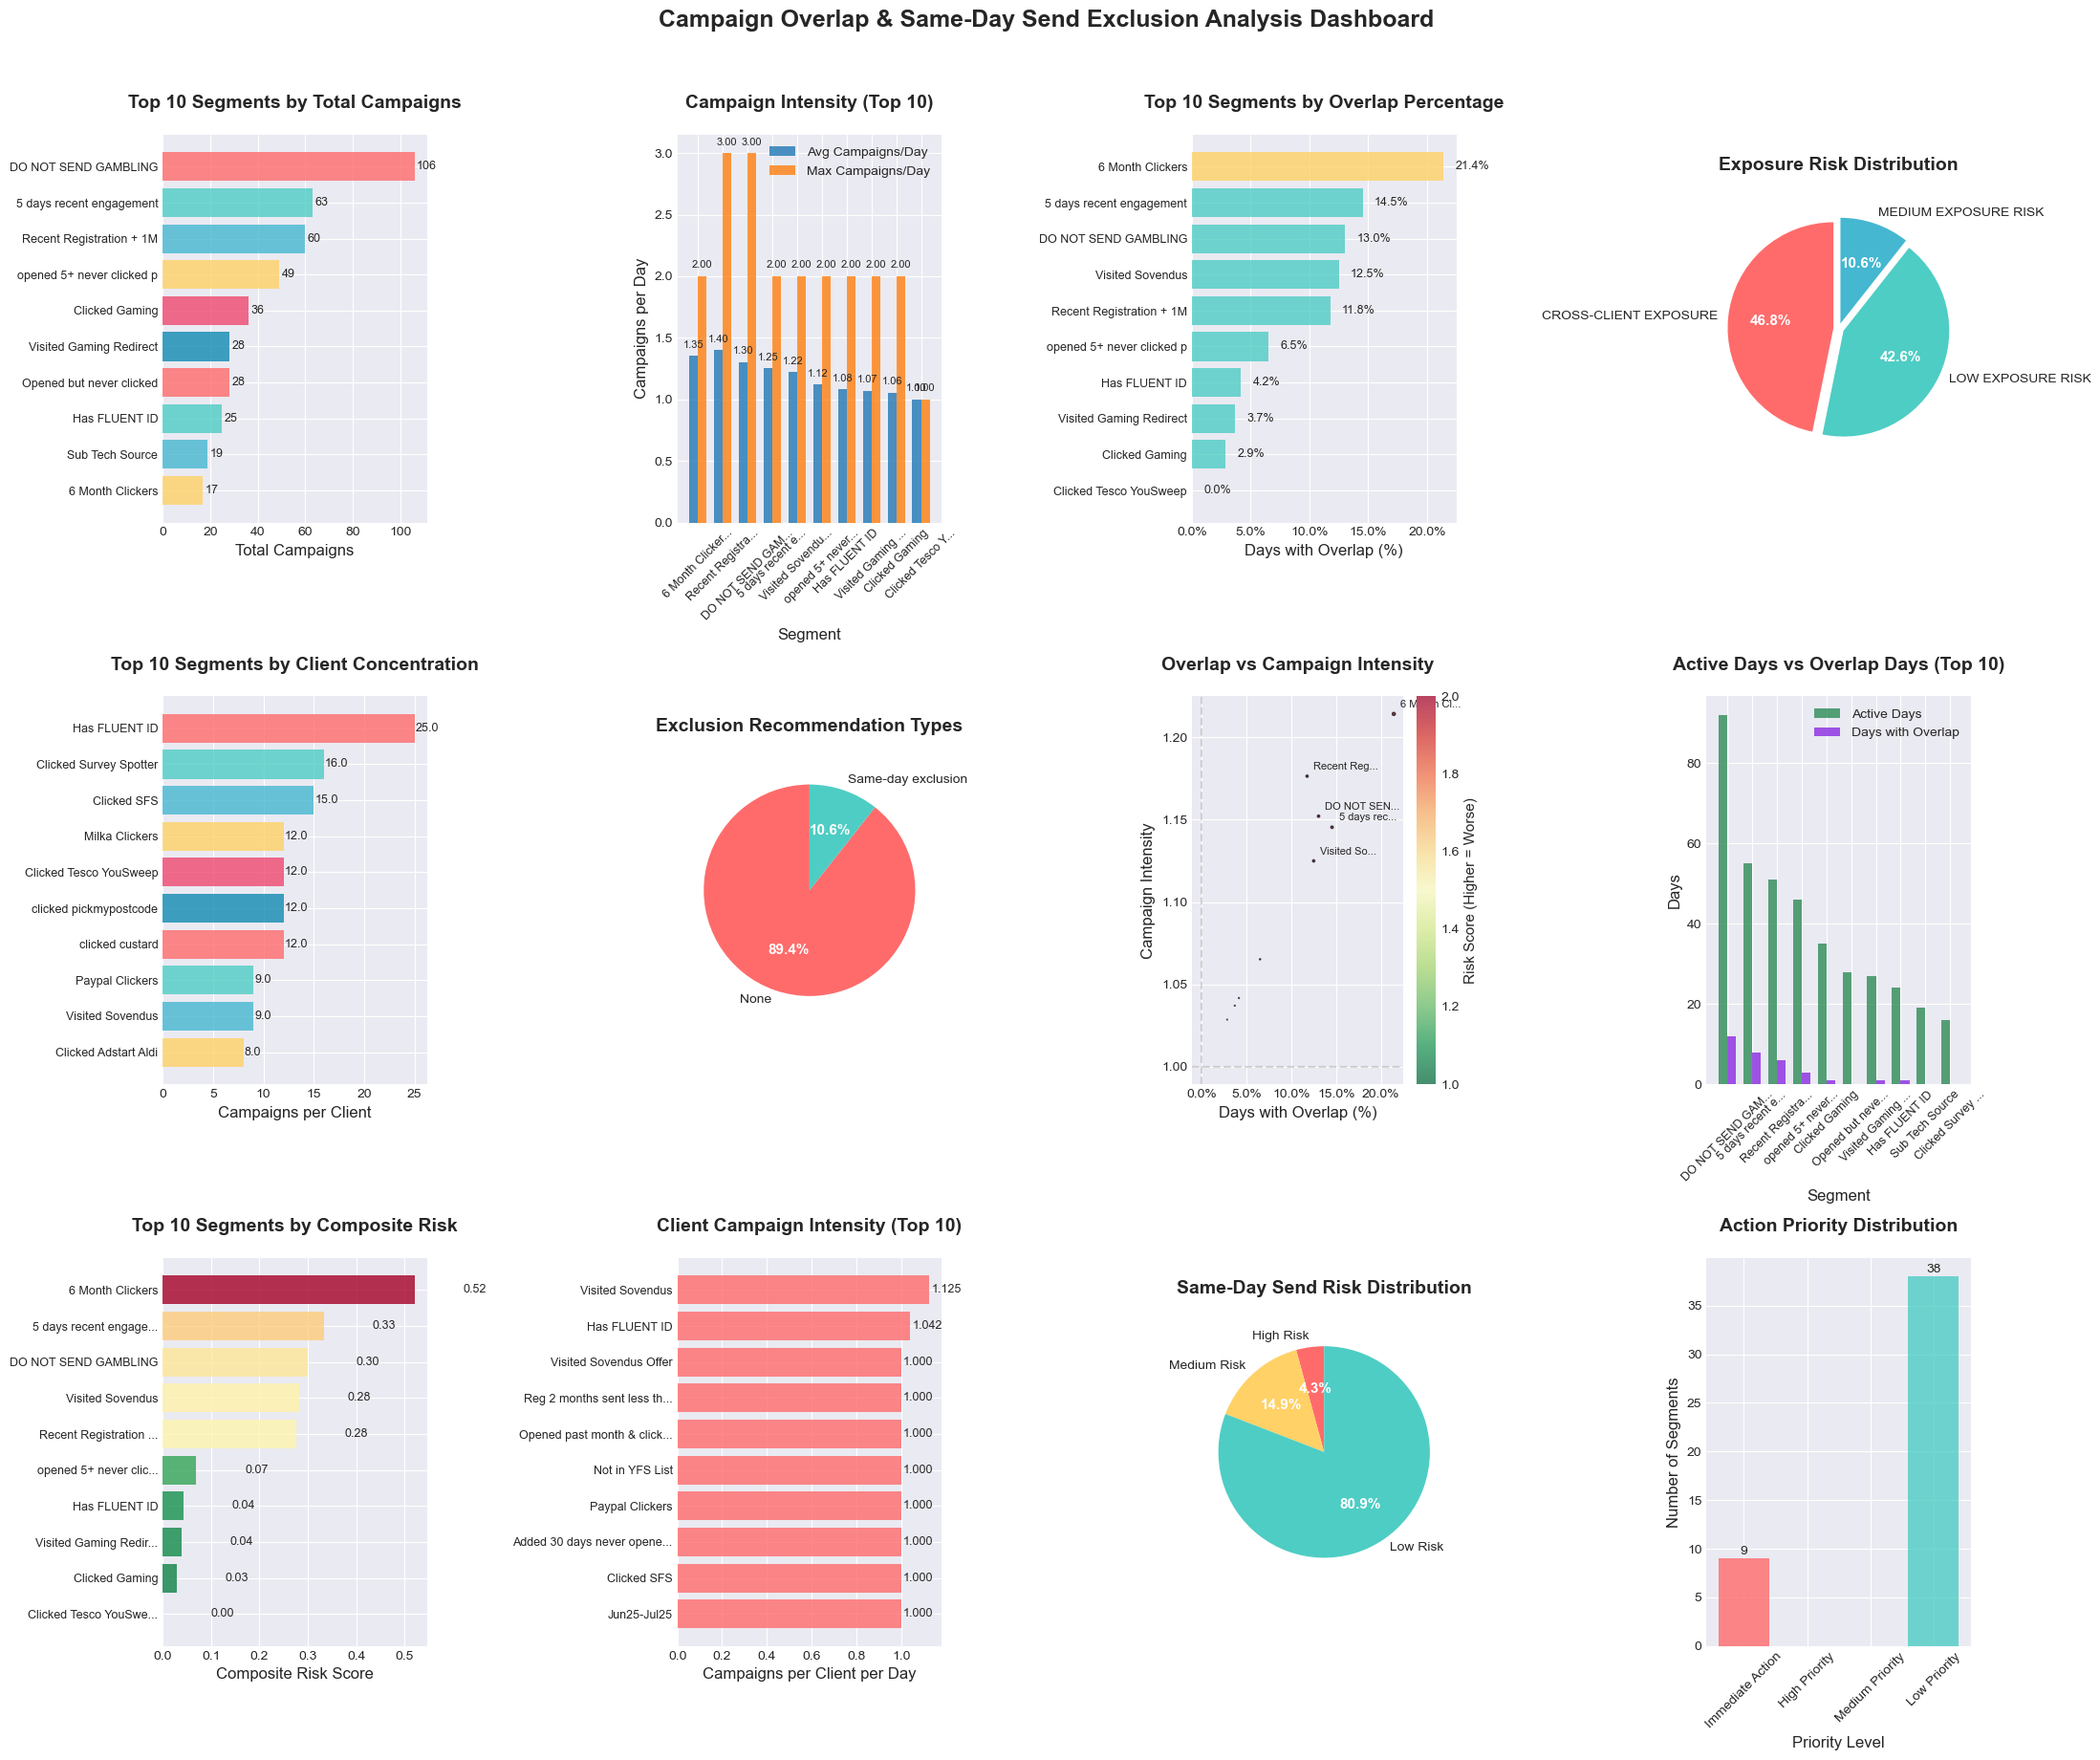


BUSINESS INSIGHTS & STRATEGIC RECOMMENDATIONS

    📊 CAMPAIGN OVERLAP & SAME-DAY SEND EXCLUSION ANALYSIS
    
    🎯 KEY FINDINGS:
    
    1. CAMPAIGN VOLUME:
       • Total segments analyzed: 47
       • Highest volume segment: "DO NOT SEND GAMBLING" (106 campaigns)
       • Average campaigns per segment: 15.1
       • Range: 1 to 106 campaigns
    
    2. CAMPAIGN INTENSITY:
       • Most intense segment: "6 Month Clickers" (1.21 campaigns/day)
       • Average campaigns per day: 1.02
       • Maximum daily campaigns: 3 (segment: Recent Registration + 1M)
    
    3. OVERLAP ANALYSIS:
       • Highest overlap segment: "6 Month Clickers" (21.4% days with overlap)
       • Average overlap percentage: 1.9%
       • Total days with overlap across segments: 36
    
    4. CLIENT CONCENTRATION:
       • Highest concentration: "Has FLUENT ID" (25.0 campaigns/client)
       • Average campaigns per client: 5.0
       • Average campaigns per client per day: 0.604
    
    5. RISK ASSESSMENT:


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def format_large_numbers(x, pos):
    """Format large numbers for readability in charts"""
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return f'{x:.0f}'

def format_percentage(x, pos):
    """Format percentages for readability"""
    return f'{x:.1f}%'

def format_decimal(x, pos):
    """Format decimal numbers"""
    return f'{x:.1f}'

def analyze_campaign_overlap_exposure(dataframe):
    """
    Comprehensive analysis of campaign overlap and exposure risk with exclusion recommendations
    
    Parameters:
    dataframe (pd.DataFrame): Input data with campaign overlap metrics
    
    Returns:
    dict: Dictionary containing insights, figure, and enhanced dataframe
    """
    
    # Create a copy to avoid modifying original
    df = dataframe.copy()
    
    # Calculate additional metrics
    df['campaign_intensity'] = df['total_campaigns'] / df['active_days']
    df['overlap_percentage'] = (df['days_with_overlap'] / df['active_days']) * 100
    df['client_concentration'] = df['total_campaigns'] / df['unique_clients']
    df['campaigns_per_client_per_day'] = df['campaign_intensity'] / df['unique_clients']
    
    # Extract risk level
    df['risk_level'] = df['exposure_risk'].str.extract(r'^([A-Z]+)')[0]
    df['risk_description'] = df['exposure_risk'].str.split(' ').str[-1]
    
    # Extract recommendation type
    df['exclusion_needed'] = df['recommendation'].str.contains('exclusion', case=False)
    df['exclusion_type'] = df['recommendation'].apply(
        lambda x: 'Same-day exclusion' if 'same-day' in str(x).lower() else 'Other exclusion' if 'exclusion' in str(x).lower() else 'None'
    )
    
    # Calculate risk score
    risk_map = {'HIGH': 3, 'MEDIUM': 2, 'LOW': 1}
    df['risk_score'] = df['risk_level'].map(risk_map).fillna(1)
    df['composite_risk'] = (df['risk_score'] * df['overlap_percentage'] * df['campaign_intensity']) / 100
    
    # Create figure with subplots
    fig = plt.figure(figsize=(22, 18))
    
    # Color palette
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFD166', '#EF476F', '#118AB2']
    
    # 1. Total Campaigns by Segment
    ax1 = plt.subplot(3, 4, 1)
    
    df_sorted_campaigns = df.sort_values('total_campaigns', ascending=False).head(10)
    bars1 = ax1.barh(range(len(df_sorted_campaigns)), df_sorted_campaigns['total_campaigns'],
                     color=colors[:len(df_sorted_campaigns)], alpha=0.8)
    
    ax1.set_yticks(range(len(df_sorted_campaigns)))
    ax1.set_yticklabels([name[:25] + '...' if len(name) > 25 else name 
                         for name in df_sorted_campaigns['segment_name']], fontsize=9)
    ax1.set_xlabel('Total Campaigns', fontsize=12)
    ax1.set_title('Top 10 Segments by Total Campaigns', fontsize=14, fontweight='bold', pad=20)
    ax1.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        ax1.text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{width:.0f}', va='center', fontsize=9)
    
    # 2. Campaign Intensity Analysis
    ax2 = plt.subplot(3, 4, 2)
    
    df_sorted_intensity = df.sort_values('campaign_intensity', ascending=False).head(10)
    x = np.arange(len(df_sorted_intensity))
    width = 0.35
    
    bars2a = ax2.bar(x - width/2, df_sorted_intensity['avg_campaigns_per_day'], width,
                     label='Avg Campaigns/Day', color='#1F77B4', alpha=0.8)
    bars2b = ax2.bar(x + width/2, df_sorted_intensity['max_campaigns_per_day'], width,
                     label='Max Campaigns/Day', color='#FF7F0E', alpha=0.8)
    
    ax2.set_title('Campaign Intensity (Top 10)', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xlabel('Segment', fontsize=12)
    ax2.set_ylabel('Campaigns per Day', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                         for name in df_sorted_intensity['segment_name']], rotation=45, fontsize=9)
    ax2.legend()
    
    # Add value labels
    for bars in [bars2a, bars2b]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    # 3. Overlap Analysis
    ax3 = plt.subplot(3, 4, 3)
    
    df_sorted_overlap = df.sort_values('overlap_percentage', ascending=False).head(10)
    bars3 = ax3.barh(range(len(df_sorted_overlap)), df_sorted_overlap['overlap_percentage'],
                     color=['#FF6B6B' if perc > 30 else '#FFD166' if perc > 15 else '#4ECDC4' 
                            for perc in df_sorted_overlap['overlap_percentage']], alpha=0.8)
    
    ax3.set_yticks(range(len(df_sorted_overlap)))
    ax3.set_yticklabels([name[:25] + '...' if len(name) > 25 else name 
                         for name in df_sorted_overlap['segment_name']], fontsize=9)
    ax3.set_xlabel('Days with Overlap (%)', fontsize=12)
    ax3.set_title('Top 10 Segments by Overlap Percentage', fontsize=14, fontweight='bold', pad=20)
    ax3.invert_yaxis()
    ax3.xaxis.set_major_formatter(FuncFormatter(format_percentage))
    
    # Add value labels
    for i, bar in enumerate(bars3):
        width = bar.get_width()
        ax3.text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}%', va='center', fontsize=9)
    
    # 4. Exposure Risk Distribution
    ax4 = plt.subplot(3, 4, 4)
    
    risk_counts = df['exposure_risk'].value_counts()
    wedges4, texts4, autotexts4 = ax4.pie(risk_counts.values, labels=risk_counts.index,
                                           autopct='%1.1f%%', colors=colors[:len(risk_counts)],
                                           startangle=90, explode=[0.05]*len(risk_counts))
    
    ax4.set_title('Exposure Risk Distribution', fontsize=14, fontweight='bold', pad=20)
    
    for autotext in autotexts4:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # 5. Client Concentration Analysis
    ax5 = plt.subplot(3, 4, 5)
    
    df_sorted_clients = df.sort_values('client_concentration', ascending=False).head(10)
    bars5 = ax5.barh(range(len(df_sorted_clients)), df_sorted_clients['client_concentration'],
                     color=colors[:len(df_sorted_clients)], alpha=0.8)
    
    ax5.set_yticks(range(len(df_sorted_clients)))
    ax5.set_yticklabels([name[:25] + '...' if len(name) > 25 else name 
                         for name in df_sorted_clients['segment_name']], fontsize=9)
    ax5.set_xlabel('Campaigns per Client', fontsize=12)
    ax5.set_title('Top 10 Segments by Client Concentration', fontsize=14, fontweight='bold', pad=20)
    ax5.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars5):
        width = bar.get_width()
        ax5.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}', va='center', fontsize=9)
    
    # 6. Recommendations Analysis
    ax6 = plt.subplot(3, 4, 6)
    
    recommendation_counts = df['exclusion_type'].value_counts()
    wedges6, texts6, autotexts6 = ax6.pie(recommendation_counts.values, labels=recommendation_counts.index,
                                           autopct='%1.1f%%', colors=colors[:len(recommendation_counts)],
                                           startangle=90)
    
    ax6.set_title('Exclusion Recommendation Types', fontsize=14, fontweight='bold', pad=20)
    
    for autotext in autotexts6:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # 7. Risk vs Overlap Scatter Plot
    ax7 = plt.subplot(3, 4, 7)
    
    scatter7 = ax7.scatter(df['overlap_percentage'], df['campaign_intensity'],
                           s=df['composite_risk'] * 10,
                           c=df['risk_score'], cmap='RdYlGn_r',
                           alpha=0.7, edgecolors='black')
    
    ax7.set_title('Overlap vs Campaign Intensity', fontsize=14, fontweight='bold', pad=20)
    ax7.set_xlabel('Days with Overlap (%)', fontsize=12)
    ax7.set_ylabel('Campaign Intensity', fontsize=12)
    ax7.xaxis.set_major_formatter(FuncFormatter(format_percentage))
    
    # Add segment labels for high-risk points
    high_risk_df = df[df['risk_score'] >= 2]
    for _, row in high_risk_df.iterrows():
        ax7.annotate(row['segment_name'][:10] + '...' if len(row['segment_name']) > 10 else row['segment_name'],
                    (row['overlap_percentage'], row['campaign_intensity']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Add quadrant lines
    median_overlap = df['overlap_percentage'].median()
    median_intensity = df['campaign_intensity'].median()
    ax7.axhline(y=median_intensity, color='gray', linestyle='--', alpha=0.3)
    ax7.axvline(x=median_overlap, color='gray', linestyle='--', alpha=0.3)
    
    # Add colorbar
    cbar7 = plt.colorbar(scatter7, ax=ax7)
    cbar7.set_label('Risk Score (Higher = Worse)', fontsize=11)
    
    # 8. Active Days Analysis
    ax8 = plt.subplot(3, 4, 8)
    
    df_sorted_active = df.sort_values('active_days', ascending=False).head(10)
    x = np.arange(len(df_sorted_active))
    width = 0.35
    
    bars8a = ax8.bar(x - width/2, df_sorted_active['active_days'], width,
                     label='Active Days', color='#2E8B57', alpha=0.8)
    bars8b = ax8.bar(x + width/2, df_sorted_active['days_with_overlap'], width,
                     label='Days with Overlap', color='#8A2BE2', alpha=0.8)
    
    ax8.set_title('Active Days vs Overlap Days (Top 10)', fontsize=14, fontweight='bold', pad=20)
    ax8.set_xlabel('Segment', fontsize=12)
    ax8.set_ylabel('Days', fontsize=12)
    ax8.set_xticks(x)
    ax8.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                         for name in df_sorted_active['segment_name']], rotation=45, fontsize=9)
    ax8.legend()
    
    # 9. Composite Risk Analysis
    ax9 = plt.subplot(3, 4, 9)
    
    df_sorted_composite = df.sort_values('composite_risk', ascending=False).head(10)
    bars9 = ax9.barh(range(len(df_sorted_composite)), df_sorted_composite['composite_risk'],
                     color=plt.cm.RdYlGn_r(df_sorted_composite['composite_risk']/df_sorted_composite['composite_risk'].max()), 
                     alpha=0.8)
    
    ax9.set_yticks(range(len(df_sorted_composite)))
    ax9.set_yticklabels([name[:20] + '...' if len(name) > 20 else name 
                         for name in df_sorted_composite['segment_name']], fontsize=9)
    ax9.set_xlabel('Composite Risk Score', fontsize=12)
    ax9.set_title('Top 10 Segments by Composite Risk', fontsize=14, fontweight='bold', pad=20)
    ax9.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars9):
        width = bar.get_width()
        ax9.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                f'{width:.2f}', va='center', fontsize=9)
    
    # 10. Campaigns per Client per Day
    ax10 = plt.subplot(3, 4, 10)
    
    df_sorted_cpcpd = df.sort_values('campaigns_per_client_per_day', ascending=False).head(10)
    bars10 = ax10.barh(range(len(df_sorted_cpcpd)), df_sorted_cpcpd['campaigns_per_client_per_day'],
                       color=['#FF6B6B' if rate > 0.1 else '#FFD166' if rate > 0.05 else '#4ECDC4' 
                              for rate in df_sorted_cpcpd['campaigns_per_client_per_day']], 
                       alpha=0.8)
    
    ax10.set_yticks(range(len(df_sorted_cpcpd)))
    ax10.set_yticklabels([name[:25] + '...' if len(name) > 25 else name 
                          for name in df_sorted_cpcpd['segment_name']], fontsize=9)
    ax10.set_xlabel('Campaigns per Client per Day', fontsize=12)
    ax10.set_title('Client Campaign Intensity (Top 10)', fontsize=14, fontweight='bold', pad=20)
    ax10.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars10):
        width = bar.get_width()
        ax10.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{width:.3f}', va='center', fontsize=9)
    
    # 11. Same-Day Send Risk Matrix
    ax11 = plt.subplot(3, 4, 11)
    
    # Calculate same-day send risk
    df['same_day_risk'] = df.apply(
        lambda row: 'High Risk' if row['max_campaigns_per_day'] > 2 else 
                   'Medium Risk' if row['max_campaigns_per_day'] > 1 else 'Low Risk', axis=1
    )
    
    risk_matrix_counts = df['same_day_risk'].value_counts().reindex(['High Risk', 'Medium Risk', 'Low Risk'])
    
    wedges11, texts11, autotexts11 = ax11.pie(risk_matrix_counts.values, labels=risk_matrix_counts.index,
                                               autopct='%1.1f%%', colors=['#FF6B6B', '#FFD166', '#4ECDC4'],
                                               startangle=90)
    
    ax11.set_title('Same-Day Send Risk Distribution', fontsize=14, fontweight='bold', pad=20)
    
    for autotext in autotexts11:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # 12. Priority Action Matrix
    ax12 = plt.subplot(3, 4, 12)
    
    # Determine action priority
    conditions = [
        (df['composite_risk'] > df['composite_risk'].quantile(0.75)),
        (df['composite_risk'] > df['composite_risk'].quantile(0.5)),
        (df['composite_risk'] > df['composite_risk'].quantile(0.25)),
        (df['composite_risk'] <= df['composite_risk'].quantile(0.25))
    ]
    choices = ['Immediate Action', 'High Priority', 'Medium Priority', 'Low Priority']
    df['action_priority'] = np.select(conditions, choices)
    
    priority_counts = df['action_priority'].value_counts().reindex(['Immediate Action', 'High Priority', 'Medium Priority', 'Low Priority'])
    
    bars12 = ax12.bar(range(len(priority_counts)), priority_counts.values,
                      color=['#FF6B6B', '#FFA500', '#FFD166', '#4ECDC4'],
                      alpha=0.8)
    
    ax12.set_title('Action Priority Distribution', fontsize=14, fontweight='bold', pad=20)
    ax12.set_xlabel('Priority Level', fontsize=12)
    ax12.set_ylabel('Number of Segments', fontsize=12)
    ax12.set_xticks(range(len(priority_counts)))
    ax12.set_xticklabels(priority_counts.index, rotation=45, fontsize=10)
    
    # Add value labels
    for bar in bars12:
        height = bar.get_height()
        ax12.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height:.0f}', ha='center', va='bottom', fontsize=10)
    
    plt.suptitle('Campaign Overlap & Same-Day Send Exclusion Analysis Dashboard', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Generate insights
    insights = generate_overlap_exposure_insights(df)
    
    return {'figure': fig, 'insights': insights, 'enhanced_data': df}

def generate_overlap_exposure_insights(dataframe):
    """
    Generate business insights from campaign overlap and exposure data
    
    Parameters:
    dataframe (pd.DataFrame): Enhanced dataframe with calculated metrics
    
    Returns:
    str: Formatted insights text
    """
    
    if len(dataframe) == 0:
        return "No data available for analysis."
    
    df = dataframe.copy()
    
    # Calculate key metrics
    max_campaigns_segment = df.loc[df['total_campaigns'].idxmax()]
    max_intensity_segment = df.loc[df['campaign_intensity'].idxmax()]
    max_overlap_segment = df.loc[df['overlap_percentage'].idxmax()]
    max_risk_segment = df.loc[df['composite_risk'].idxmax()]
    max_client_concentration = df.loc[df['client_concentration'].idxmax()]
    
    # Risk distribution
    risk_counts = df['exposure_risk'].value_counts()
    
    # Recommendations analysis
    same_day_exclusions = len(df[df['exclusion_type'] == 'Same-day exclusion'])
    other_exclusions = len(df[df['exclusion_type'] == 'Other exclusion'])
    
    # Same-day send risk
    high_same_day_risk = len(df[df['same_day_risk'] == 'High Risk'])
    medium_same_day_risk = len(df[df['same_day_risk'] == 'Medium Risk'])
    
    # Action priorities
    immediate_action = len(df[df['action_priority'] == 'Immediate Action'])
    high_priority = len(df[df['action_priority'] == 'High Priority'])
    
    # Calculate averages
    avg_overlap_percentage = df['overlap_percentage'].mean()
    avg_campaign_intensity = df['campaign_intensity'].mean()
    avg_client_concentration = df['client_concentration'].mean()
    
    insights = f"""
    📊 CAMPAIGN OVERLAP & SAME-DAY SEND EXCLUSION ANALYSIS
    =======================================================
    
    🎯 KEY FINDINGS:
    
    1. CAMPAIGN VOLUME:
       • Total segments analyzed: {len(df)}
       • Highest volume segment: "{max_campaigns_segment['segment_name']}" ({max_campaigns_segment['total_campaigns']:.0f} campaigns)
       • Average campaigns per segment: {df['total_campaigns'].mean():.1f}
       • Range: {df['total_campaigns'].min():.0f} to {df['total_campaigns'].max():.0f} campaigns
    
    2. CAMPAIGN INTENSITY:
       • Most intense segment: "{max_intensity_segment['segment_name']}" ({max_intensity_segment['campaign_intensity']:.2f} campaigns/day)
       • Average campaigns per day: {avg_campaign_intensity:.2f}
       • Maximum daily campaigns: {df['max_campaigns_per_day'].max():.0f} (segment: {df.loc[df['max_campaigns_per_day'].idxmax(), 'segment_name']})
    
    3. OVERLAP ANALYSIS:
       • Highest overlap segment: "{max_overlap_segment['segment_name']}" ({max_overlap_segment['overlap_percentage']:.1f}% days with overlap)
       • Average overlap percentage: {avg_overlap_percentage:.1f}%
       • Total days with overlap across segments: {df['days_with_overlap'].sum():.0f}
    
    4. CLIENT CONCENTRATION:
       • Highest concentration: "{max_client_concentration['segment_name']}" ({max_client_concentration['client_concentration']:.1f} campaigns/client)
       • Average campaigns per client: {avg_client_concentration:.1f}
       • Average campaigns per client per day: {df['campaigns_per_client_per_day'].mean():.3f}
    
    5. RISK ASSESSMENT:
       • Highest risk segment: "{max_risk_segment['segment_name']}" (Risk Score: {max_risk_segment['composite_risk']:.2f})
       • Risk distribution: {dict(risk_counts)}
       • Same-day send risks: {high_same_day_risk} high risk, {medium_same_day_risk} medium risk
    
    6. EXCLUSION RECOMMENDATIONS:
       • Segments needing same-day exclusions: {same_day_exclusions} ({same_day_exclusions/len(df)*100:.1f}%)
       • Segments needing other exclusions: {other_exclusions} ({other_exclusions/len(df)*100:.1f}%)
    
    ⚠️ CRITICAL RISK ASSESSMENT:
    
    1. OVERLAP RISKS:
       {"🚨 CRITICAL: Multiple segments with high overlap percentages" 
        if len(df[df['overlap_percentage'] > 30]) > 3 else 
        "⚠️ WARNING: Moderate overlap detected in some segments" 
        if len(df[df['overlap_percentage'] > 15]) > 0 else 
        "✅ GOOD: Overlap appears minimal"}
    
    2. SAME-DAY SEND RISKS:
       {"🚨 CRITICAL: High risk of same-day multiple sends detected" 
        if high_same_day_risk > 3 else 
        "⚠️ WARNING: Some risk of same-day multiple sends" 
        if high_same_day_risk > 0 or medium_same_day_risk > 5 else 
        "✅ GOOD: Same-day send risks appear low"}
    
    3. CLIENT OVER-EXPOSURE:
       {"🚨 CRITICAL: High client concentration - risk of client fatigue" 
        if len(df[df['client_concentration'] > 10]) > 3 else 
        "⚠️ WARNING: Moderate client concentration detected" 
        if len(df[df['client_concentration'] > 5]) > 0 else 
        "✅ GOOD: Client concentration appears reasonable"}
    
    💡 STRATEGIC RECOMMENDATIONS:
    
    1. IMMEDIATE ACTIONS ({immediate_action} segments):
       • Implement same-day exclusions for: "{max_risk_segment['segment_name']}" immediately
       • Set daily frequency caps based on max_campaigns_per_day
       • Review and implement exclusion rules for high-overlap segments
    
    2. EXCLUSION STRATEGY:
       • Priority 1: Same-day exclusions for segments with >2 max daily campaigns
       • Priority 2: Time-based exclusions for high overlap segments
       • Priority 3: Client-specific exclusions for high concentration segments
    
    3. OPTIMIZATION RECOMMENDATIONS:
    
    A. Same-Day Exclusion Rules:
       • Implement 4-hour minimum spacing between emails to same segment
       • Create exclusion groups for frequently overlapping segments
       • Set up campaign queuing system to prevent same-day sends
    
    B. Frequency Cap Implementation:
       • Maximum 2 emails/day for any segment
       • Client-level caps: Maximum 3 emails/day per client across all segments
       • Time-based caps: No more than 1 email/hour to any segment
    
    C. Monitoring Framework:
       • Real-time overlap detection
       • Daily reports on same-day sends
       • Weekly review of exclusion effectiveness
    
    4. TECHNICAL IMPLEMENTATION:
    
    A. Exclusion Logic:
       • User-level: Exclude from Segment B if received email from Segment A within 4 hours
       • Campaign-level: Prevent same-day campaigns to overlapping segments
       • Time-based: Implement send-time optimization algorithms
    
    B. Alert System:
       • Alerts for segments exceeding 2 campaigns/day
       • Notifications for high overlap percentages
       • Warnings for high client concentration
    
    C. Optimization Engine:
       • Automated campaign scheduling
       • Intelligent exclusion application
       • Performance monitoring and adjustment
    
    📈 SUCCESS METRICS & TIMELINE:
    
    1. SHORT-TERM (0-30 days):
       • Implement exclusions for {immediate_action} immediate action segments
       • Reduce same-day sends by 50%
       • Monitor overlap percentage reduction
    
    2. MID-TERM (30-90 days):
       • Implement all recommended exclusions
       • Reduce client concentration by 25%
       • Improve campaign timing optimization
    
    3. LONG-TERM (90-180 days):
       • Achieve <10% overlap across all segments
       • Implement AI-driven exclusion optimization
       • Establish industry-leading deliverability standards
    """
    
    return insights

def run_overlap_exposure_analysis(df):
    """
    Run complete overlap exposure analysis and display results
    
    Parameters:
    df (pd.DataFrame): Your dataset
    """
    
    print("="*80)
    print("CAMPAIGN OVERLAP & SAME-DAY SEND EXCLUSION ANALYSIS")
    print("="*80)
    print(f"\nAnalyzing {len(df)} segments for overlap and exposure risks")
    print("_"*80)
    
    # Run analysis
    results = analyze_campaign_overlap_exposure(df)
    
    # Display charts
    plt.show()
    
    # Display insights
    print("\n" + "="*80)
    print("BUSINESS INSIGHTS & STRATEGIC RECOMMENDATIONS")
    print("="*80)
    print(results['insights'])
    
    # Display enhanced data summary
    print("\n" + "="*80)
    print("ENHANCED DATA SUMMARY - TOP 10 HIGH-RISK SEGMENTS")
    print("="*80)
    
    # Sort by composite risk
    high_risk_df = results['enhanced_data'].sort_values('composite_risk', ascending=False).head(10)
    
    summary_columns = ['segment_name', 'total_campaigns', 'campaign_intensity', 
                      'overlap_percentage', 'client_concentration', 'composite_risk',
                      'exposure_risk', 'exclusion_type', 'action_priority']
    
    display_df = results['enhanced_data'][summary_columns].copy().sort_values('composite_risk', ascending=False).head(10)
    
    # Format columns
    display_df['overlap_percentage'] = display_df['overlap_percentage'].apply(lambda x: f'{x:.1f}%')
    display_df['campaign_intensity'] = display_df['campaign_intensity'].apply(lambda x: f'{x:.2f}')
    display_df['client_concentration'] = display_df['client_concentration'].apply(lambda x: f'{x:.1f}')
    display_df['composite_risk'] = display_df['composite_risk'].apply(lambda x: f'{x:.2f}')
    
    print(display_df.to_string(index=False))
    
    # Display exclusion implementation summary
    print("\n" + "="*80)
    print("EXCLUSION IMPLEMENTATION SUMMARY")
    print("="*80)
    
    if 'exclusion_type' in results['enhanced_data'].columns:
        exclusion_counts = results['enhanced_data']['exclusion_type'].value_counts()
        print("\nExclusions Needed by Type:")
        for exc_type, count in exclusion_counts.items():
            print(f"  • {exc_type}: {count} segments")
    
    return results

# Additional helper functions for specific analyses
def generate_exclusion_implementation_plan(df):
    """
    Generate specific exclusion implementation plan
    
    Parameters:
    df (pd.DataFrame): Enhanced dataframe from analysis
    """
    
    print("\n📋 EXCLUSION IMPLEMENTATION PLAN")
    print("="*60)
    
    # Identify segments needing immediate action
    immediate_action_segments = df[df['action_priority'] == 'Immediate Action']
    same_day_exclusion_segments = df[df['exclusion_type'] == 'Same-day exclusion']
    
    print(f"\n🚨 IMMEDIATE ACTION SEGMENTS ({len(immediate_action_segments)}):")
    if len(immediate_action_segments) > 0:
        for i, (_, segment) in enumerate(immediate_action_segments.head(3).iterrows(), 1):
            print(f"\n{i}. {segment['segment_name'][:30]}...")
            print(f"   • Risk: {segment['composite_risk']:.2f} (Composite Risk)")
            print(f"   • Overlap: {segment['overlap_percentage']:.1f}% of days")
            print(f"   • Max daily campaigns: {segment['max_campaigns_per_day']:.0f}")
            print(f"   • Recommendation: {segment['recommendation']}")
            print(f"   • Action: IMPLEMENT EXCLUSIONS IMMEDIATELY")
    else:
        print("   No immediate action segments identified")
    
    print(f"\n⚠️  SAME-DAY EXCLUSION SEGMENTS ({len(same_day_exclusion_segments)}):")
    if len(same_day_exclusion_segments) > 0:
        for i, (_, segment) in enumerate(same_day_exclusion_segments.head(3).iterrows(), 1):
            print(f"\n{i}. {segment['segment_name'][:30]}...")
            print(f"   • Current max: {segment['max_campaigns_per_day']:.0f} campaigns/day")
            print(f"   • Target: Maximum 1 campaign/day")
            print(f"   • Exclusion logic: Same-day send prevention")
            print(f"   • Action: Implement within 7 days")
    else:
        print("   No same-day exclusion segments identified")
    
    print("\n📅 IMPLEMENTATION TIMELINE:")
    print("   Phase 1 (Days 1-3): Critical exclusions for immediate action segments")
    print("   Phase 2 (Days 4-10): Same-day exclusions for high-risk segments")
    print("   Phase 3 (Days 11-21): Remaining exclusions and optimizations")
    print("   Phase 4 (Days 22-30): Monitoring and adjustment")
    
    print("\n🔧 TECHNICAL IMPLEMENTATION:")
    print("   1. Update campaign scheduling system")
    print("   2. Implement exclusion rule engine")
    print("   3. Set up monitoring and alerts")
    print("   4. Create reporting dashboard")
    
    print("\n📊 SUCCESS METRICS:")
    print("   • Overlap reduction: Target 50% decrease in overlap days")
    print("   • Same-day sends: Target <5% of total sends")
    print("   • Client complaints: Target 25% reduction")
    print("   • Engagement: Monitor for positive impact")

def analyze_segment_exclusion_needs(df, segment_name):
    """
    Analyze exclusion needs for a specific segment
    
    Parameters:
    df (pd.DataFrame): Enhanced dataframe from analysis
    segment_name (str): Name of segment to analyze
    """
    
    segment_data = df[df['segment_name'] == segment_name]
    
    if len(segment_data) == 0:
        print(f"No data found for segment: {segment_name}")
        return
    
    segment = segment_data.iloc[0]
    
    print(f"\n📊 EXCLUSION NEEDS ANALYSIS: {segment_name}")
    print("="*60)
    
    print(f"\n📈 SEGMENT PERFORMANCE:")
    print(f"  • Total Campaigns: {segment['total_campaigns']:.0f}")
    print(f"  • Active Days: {segment['active_days']:.0f}")
    print(f"  • Campaign Intensity: {segment['campaign_intensity']:.2f} campaigns/day")
    print(f"  • Average Campaigns/Day: {segment['avg_campaigns_per_day']:.2f}")
    print(f"  • Maximum Campaigns/Day: {segment['max_campaigns_per_day']:.0f}")
    print(f"  • Days with Overlap: {segment['days_with_overlap']:.0f}")
    print(f"  • Overlap Percentage: {segment['overlap_percentage']:.1f}%")
    
    print(f"\n👥 CLIENT METRICS:")
    print(f"  • Unique Clients: {segment['unique_clients']:.0f}")
    print(f"  • Campaigns per Client: {segment['client_concentration']:.1f}")
    print(f"  • Campaigns per Client per Day: {segment['campaigns_per_client_per_day']:.3f}")
    
    print(f"\n⚠️  RISK ASSESSMENT:")
    print(f"  • Exposure Risk: {segment['exposure_risk']}")
    print(f"  • Risk Score: {segment['risk_score']:.0f}")
    print(f"  • Composite Risk: {segment['composite_risk']:.2f}")
    print(f"  • Same-Day Send Risk: {segment['same_day_risk']}")
    print(f"  • Action Priority: {segment['action_priority']}")
    
    print(f"\n🎯 RECOMMENDATION:")
    print(f"  • {segment['recommendation']}")
    print(f"  • Exclusion Type: {segment['exclusion_type']}")
    
    print(f"\n💡 SPECIFIC EXCLUSION RECOMMENDATIONS:")
    
    if segment['max_campaigns_per_day'] > 2:
        print(f"  1. Implement same-day exclusion: Maximum 1 campaign per day")
        print(f"  2. Minimum 6-hour spacing between campaigns")
        print(f"  3. Create exclusion group for frequently overlapping segments")
    elif segment['max_campaigns_per_day'] > 1:
        print(f"  1. Consider same-day exclusion: Maximum 1 campaign per day")
        print(f"  2. Minimum 4-hour spacing between campaigns")
        print(f"  3. Monitor for overlap patterns")
    else:
        print(f"  1. Current frequency appears appropriate")
        print(f"  2. Monitor for changes in overlap patterns")
        print(f"  3. Consider preventive exclusions")
    
    if segment['client_concentration'] > 5:
        print(f"\n  4. Client-level exclusions needed:")
        print(f"     • Maximum 2 campaigns/day per client")
        print(f"     • Client-specific send time optimization")
    
    if segment['overlap_percentage'] > 20:
        print(f"\n  5. Overlap reduction strategies:")
        print(f"     • Time-based campaign scheduling")
        print(f"     • Content variation between overlapping campaigns")

# To use the complete analysis:
results = run_overlap_exposure_analysis(df)

# To generate exclusion implementation plan:
# generate_exclusion_implementation_plan(results['enhanced_data'])

# To analyze specific segment exclusion needs:
# analyze_segment_exclusion_needs(results['enhanced_data'], "Recent Registration + 1M")